# Local HR measurement to Music

Heart rate and heart rate variability are features of cardiac activity that seem to vary meaningfully during music performance and listening. However, traditional estimates of individual's heart rate and features of heart rate variability are usually calculated over longer time intervals, minutes or hours rather than seconds or beat by beat, and these calculations are not all suitable for active conditions where physical activity is a substantial contributor to these features values in time.

In order to investigate the temporal dynamics of cardiac activity at a time scale relevant to the actions and conscious experience of musical activities, we need reliable robust calculations for extremely local values, per beat if possible, that also untangle cardiac qualities of interest. 

Some of the challenges for higher temporal resolution on these features is a matter of signal reliability. The cardiac features of interest are all derived from measured cardiac IBIs, interbeat-intervals. Active measurement conditions such as music playing or dancing can produce interference that disturb the reliability of beat detection and infered timing from most sensor systems. Automated data cleaning and strategies to acknowledge, navigate around, and compensate for missing data is necessary for higher resolution data handling. 

Using IBIs recorded from musicians and listeners during live performances. this notebook presents comparisons and recommendations:

    1. IBI cleaning
    2. Local HR 
    
HRV measurements are explained in the LocalHRV notebook. Some of the functions defined in this notebooks are retained for use elsewhere via the accompanying mh.py function file 

This analysis includes arguments about the repeatability of these measurement values across repeated performances, the consistency of values between performers playing similar parts, and the seperability of HR and HRV in these measurement conditions. 

# Code libraries, published and local

In [1]:
import sys
import os
import time
import datetime as dt
import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import heartpy as hp
import pingouin as pg

from scipy.signal import butter, filtfilt, argrelextrema
from scipy import interpolate
from scipy.interpolate import interp1d

In [2]:
%load_ext autoreload
%autoreload 1
%aimport qex
%aimport al
%aimport eq
%aimport rp

In [3]:
%reload_ext autoreload

In [4]:
data_loc = './demodata/'
demofiles = os.listdir(data_loc)
plot_loc = './plots/'
mydpi = 196

# IBI Cleaning

IBI or RR files are time series derived from eletrocardiogram (ECG) or photoplethsomgraphy (PP) measurements that give the timing of maximal contraction or pressure and estimated time since the last maximal value, e.i., the period of the last heart beat. The algorithms for extracting IBI or RR time lists depend on the sensor and signal being used to collect these values. However, in theory, and with a little wiggle room for sample rate differences, IBI estimates generated by concurrently measuring sensors should be very similiar for the same signal. If the IBI extractions are reliable and the device clocks aligned, one or two line ECG should agree on peak timings and time since last peak. IBIs from PP on a finger may be a few seconds behind because of the pressure wave travel time from heart to limb extremities, but it should follow the same trajectory. 

However, the reliability of these values can be affected by sensor noise. For example, movement can produce extraneous peaks in ECG measurements (at least in some sensor types and electrode placements), misplacing the beat (early or late relative to real beat time), introducing false intermediate beats, or obscuring it entirely. These sensor noise errors produce sudden local changes in IBI values that need to handled with care.

There is also a lot of inter-participant differences in IBI measurement character and quality. Variation in the characteristic shape of the ECG wave can result in poor peak detection with standard algorithms. There are also real instances of sudden extreme IBI deviations, with the heart skipping or suddenly delaying the beat for reasons outside of our domain of interest. Researchers studying the effects of music on the body are not (usually) cardiologists with the knowledge or expertese to engage with complex cardiac conditions. It's a matter of researcher judgement, whether an individual's recordings can be used to learn common patterns of cardiac activity during music, whether to reduce such deviations as "noise" in the heart-music signal or informative other reasons. 

All told, IBI measurement cleaning practices need to be applied with an awareness of what problems they are solving and may be making for future analysis. Here we demonstrate of a few examples that vary in:

    1. Heart Rate range: small or large
    2. Signal noise (intrinsicly extra variable HR)
    3. Sensor noise (measurement quality problems in ECG)

In [5]:
def clean_IBI(beatTimes,beatIntervals,activitytype='default'):
    # function to clean IBI measurements to compensate for common intermittent sensor noise problems and some signal deviations that will complicate upstream calculations. This is not magic, bad signals are bad signals. This is just help.
    # Successive IBI values that exceed trusted behaviour are either:
    #     cut (higher octave errors) or 
    #     replaced with NA (alignment errors, lower octave errors)
    #
    # input: 
    #   beatTimes: seconds timestampe of beats recorded in seconds
    #   beatIntervals: ms time from previous beat , as output by sensor system or heartpy, same length as beatTimes
    #   activitytype: 'default' - non-respiratory musicians
    #               'resp' - respiratory musicians (winds, brass, singers)
    #               'listener' - seated listener, not performer, not singing alone
    # other potential activity types: dancer, singer/flute as distinct from winds with resistant mouth pieces (higher pressure)
    #
    # output:
    #   IBI = pandas dataframe with timestamps in seconds as index and IBI in ms as first column, with cut IBIs replaced with NA
    sig_t = pd.Series(beatTimes)
    if beatIntervals is None:
        sig_v = sig_t.diff()*1000
    else:
        sig_v = pd.Series(beatIntervals)
    if activitytype=='default':
        # make na beats that change more than 10% duration 
        sig_v_pre = np.log2(sig_v/sig_v.shift(1)).abs()
        sig_v_post = np.log2(sig_v.shift(-1)/sig_v).abs()
        sig_v = sig_v.mask((sig_v_post>0.15) & (sig_v_pre>0.15))
         # BPM cut offs, 48 to 167, 
        sig_v = sig_v.mask(sig_v<360)
        sig_v = sig_v.mask(sig_v>1250)
    if activitytype=='resp':
        # make na beats that change more than 25% duration, brass and winds need more forgiving thresholds
        sig_v_pre = np.log2(sig_v/sig_v.shift(1)).abs()
        sig_v_post = np.log2(sig_v.shift(-1)/sig_v).abs()
        sig_v = sig_v.mask((sig_v_post>0.45) & (sig_v_pre>0.45))
         # BPM cut offs, 48 to 182
        sig_v =sig_v.mask(sig_v<330)
        sig_v =sig_v.mask(sig_v>1250)
    if activitytype=='listener':
        # make na beats that change more than 15% duration,  
        sig_v_pre = np.log2(sig_v/sig_v.shift(1)).abs()
        sig_v_post = np.log2(sig_v.shift(-1)/sig_v).abs()
        sig_v = sig_v.mask((sig_v_post>0.2) & (sig_v_pre>0.2))
        # BPM cut offs, 48 to 150
        sig_v =sig_v.mask(sig_v<400)
        sig_v =sig_v.mask(sig_v>1250)
    
    IBI = pd.DataFrame(columns= ['time','IBI'])
    IBI['IBI'] = sig_v 
    IBI['time'] = sig_t
    IBI.set_index('time',drop = True, inplace = True)
    return IBI


In [6]:
#def clean_IBI(beatTimes,beatIntervals,activitytype='default'):

def ibi_beatfeats(sig_t,sig_v):
    # assume cleaned with IBI_clean, then ibi_beatfeats(IBI.index,IBI.IBI)
#     sig_v =sig_v.mask(sig_v.diff().abs()>120)
#     sig_v =sig_v.mask(sig_v<300)
    min_per = 5

    df_card = pd.DataFrame()
    df_card['time'] = sig_t
    df_card['IBI'] = sig_v 
    
    sig_t = pd.Series(sig_t)
    sig_v = pd.Series(sig_v)
    HR = (60000/sig_v)
    cutHR = HR[HR.notna()]
    f = interpolate.interp1d(sig_t[HR.notna()],HR[HR.notna()],kind = 'linear')
    new_t = sig_t[cutHR.index.min():cutHR.index.max()]
    newHR = f(new_t)
    df_card['HR1bt'] = HR
    df_card['normHR1bt'] = (HR - np.min([cutHR.quantile(0.10),80]))/np.max([30,cutHR.quantile(0.98)- cutHR.quantile(0.10)])

    df_card.loc[:,'HR10bt'] = (60000/sig_v).rolling(10,center=True,min_periods=min_per).median() # really lazy smoothing
    df_card.loc[:,'HR30bt'] = (60000/sig_v).rolling(30,center=True,min_periods=min_per).median() # really lazy smoothing
    
#     df_card.loc[:,'HRV10bt_ms'] = sig_v.diff().pow(2).rolling(10,center=True,min_periods=min_per).mean().pow(0.5)
#     df_card.loc[:,'HRV30bt_ms'] = sig_v.diff().pow(2).rolling(30,center=True,min_periods=min_per).mean().pow(0.5)
#     df_card.loc[:,'HRV10bt_qms'] = sig_v.diff().rolling(10,center=True,min_periods=min_per).quantile(0.75)-sig_v.diff().rolling(10,center=True,min_periods=min_per).quantile(0.25)
#     df_card.loc[:,'HRV30bt_qms'] = sig_v.diff().rolling(30,center=True,min_periods=min_per).quantile(0.75)-sig_v.diff().rolling(30,center=True,min_periods=min_per).quantile(0.25)

#     a = sig_v.copy()
#     division = pd.Series(np.divide(a.values[1:],a.values[:-1]))
#     a.loc[1:] = division
#     a.loc[0]=1
#     a.iloc[-1]=1
#     df_card.loc[:,'HRV10bt_r'] = (a-1).abs().rolling(10,center=True,min_periods=min_per).median()+1
#     df_card.loc[:,'HRV30bt_r'] = (a-1).abs().rolling(30,center=True,min_periods=min_per).median()+1
#     a = np.log2(a)
#     df_card.loc[:,'HRV10bt_ar'] = np.exp2(a.rolling(10,center=True,min_periods=min_per).quantile(0.75)-a.rolling(10,center=True,min_periods=min_per).quantile(0.25))
#     df_card.loc[:,'HRV30bt_ar']  = np.exp2(a.rolling(30,center=True,min_periods=min_per).quantile(0.75)-a.rolling(30,center=True,min_periods=min_per).quantile(0.25))
    df_card.set_index('time',drop = True, inplace = True)
 
    return df_card

def ibi_sbeatfeats(sig_t,sig_v):
    # assume cleaned with IBI_clean, then ibi_beatfeats(IBI.index,IBI.IBI)
#     sig_v =sig_v.mask(sig_v.diff().abs()>120)
#     sig_v =sig_v.mask(sig_v<300)
    min_per = 5

    df_card = pd.DataFrame()
    df_card['time'] = sig_t
    df_card['IBI'] = sig_v 
    
    sig_t = pd.Series(sig_t)
    sig_v = pd.Series(sig_v)
    HR = (60000/sig_v)
    cutHR = HR[HR.notna()]
    f = interpolate.interp1d(sig_t[HR.notna()],HR[HR.notna()],kind = 'linear')
    new_t = sig_t[cutHR.index.min():cutHR.index.max()]
    newHR = f(new_t)
    df_card['HR1bt'] = HR
    df_card['normHR1bt'] = (HR - np.min([cutHR.quantile(0.10),80]))/np.max([30,cutHR.quantile(0.98)- cutHR.quantile(0.10)])
    df_card.set_index('time',drop = True, inplace = True)
    
    df_card.loc[:,'HR10s'] = np.nan
    s = 10
    for i in df_card.loc[(df_card.index > df_card.index[0]+s/2) & (df_card.index < df_card.index[-1]-s/2),:].index:
        df_card.loc[i,'HR10s'] = df_card.loc[(df_card.index < i+s/2) & (df_card.index > i-s/2),'HR1bt'].mean()
        
    df_card.loc[:,'HR30s'] = np.nan
    s = 30        
    for i in df_card.loc[(df_card.index > df_card.index[0]+s/2) & (df_card.index < df_card.index[-1]-s/2),:].index:
        df_card.loc[i,'HR30s'] = df_card.loc[(df_card.index < i+s/2) & (df_card.index > i-s/2),'HR1bt'].mean()

    return df_card


def ibi_feats(sig_t,sig_v,time_s):
# assume cleaned with IBI_clean, then ibi_beatfeats(IBI.index,IBI.IBI)
#     sig_v =sig_v.mask(sig_v.diff().abs()>120)
#     sig_v =sig_v.mask(sig_v<300)
    df_card = ibi_beatfeats(sig_t,sig_v)
    df_ts = pd.DataFrame(index = time_s)
    for c in df_card.columns:
            f = interpolate.interp1d(sig_t,df_card.loc[:,c].values,fill_value='extrapolate')
            df_ts.loc[:,c] = f(time_s)
    
    return df_ts

In [7]:
def refeats(df_s,time_s):
#     sf = 1/pd.Series(time_s).diff().mode().values[0]
    r_df = pd.DataFrame(index = time_s, columns = df_s.columns)
    for c in df_s.columns:
        f = interpolate.interp1d(df_s.index, df_s[c],fill_value='extrapolate')
        r_df.loc[:,c] = f(time_s)
    return r_df
def scaledcoh(df_s,frame_sizes,step=1):
    sf = 1/pd.Series(df_s.index).diff().mode().values[0]
    # need to adapt pcoor dimensions to correct for indexing on a step greater than a sample
    pcoor = pd.DataFrame(index = df_s.index, columns = frame_sizes)
    for j in range(len(frame_sizes)):
        fr = int((frame_sizes[j]*sf)/2)
        for i in range(fr,len(df_s.index)-fr,step):
            frame = df_s.iloc[i-fr:i+fr,:]
            pcoor.iloc[i,j] = frame.mean(axis=1).std()/(frame.std(axis=0).mean())
            
    return pcoor.astype(float)

# Cardiac related signals
BPM and ECG and Resp concurrently measured.

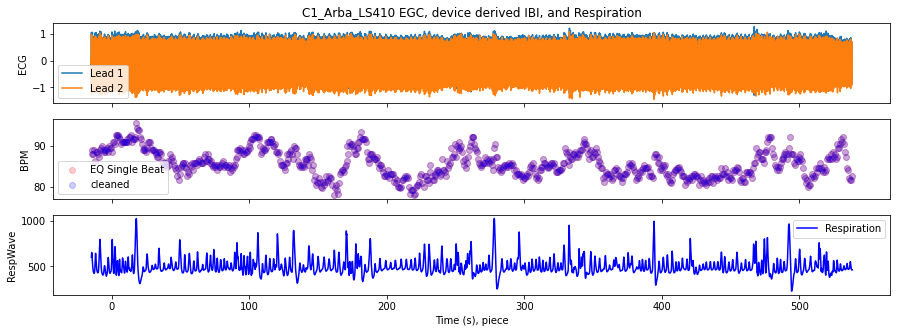

In [9]:
sig_ex = 'C1_Arba_LS410'
V = pd.read_csv(data_loc + sig_ex+'_EQCIBI.csv', index_col = 0)
sig_t = V['p_sTime']
sig_v = V['Interbeat Interval (MS)']
C = pd.read_csv(data_loc + sig_ex + '_EQ2ECG.csv', index_col = 0)
R = pd.read_csv(data_loc + sig_ex + '_EQRESP.csv', index_col = 0)

IBI=clean_IBI(sig_t,sig_v,activitytype='default')

fig, (ax) = plt.subplots(3, 1,figsize = [15,5],sharex = True)
ax[1].scatter(x =sig_t,y=(60000/sig_v),color='r',alpha = 0.2,label='EQ Single Beat')
ax[1].scatter(x = IBI.index,y = (60000/IBI['IBI']),color='b',alpha = 0.2,label='cleaned')
ax[1].set_ylabel('BPM')
ax[0].plot(C['p_sTime'],C[['Lead 1','Lead 2']],label=['Lead 1','Lead 2'])
ax[0].set_ylabel('ECG')
ax[2].plot(R['p_sTime'],R['Breathing'],color = 'b',label='Respiration')
ax[2].set_xlabel('Time (s), piece')
ax[2].set_ylabel('RespWave')
ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[0].set_title(sig_ex +' EGC, device derived IBI, and Respiration')
plt.savefig(plot_loc+'_'.join([sig_ex,'Cardio','Resp'])+'.png',dpi=mydpi)

plt.show()

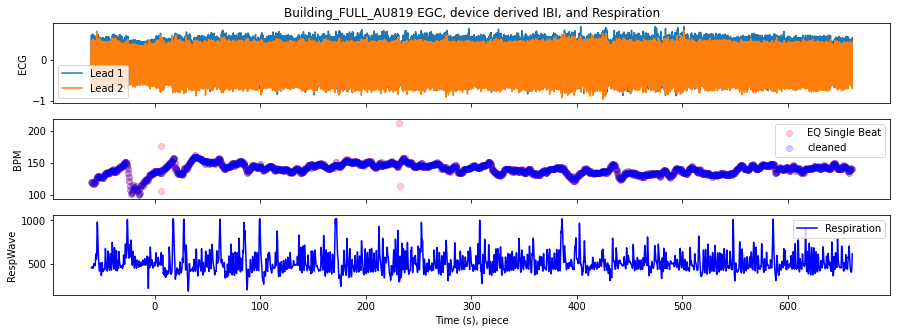

In [15]:
# sig_ex = 'C1_Arba_LS410'
sig_ex = 'Building_FULL_AU819'
V = pd.read_csv(data_loc + sig_ex+'_EQCIBI.csv', index_col = 0)
V.loc[:,'p_sTime']  = V.index
sig_t = V['p_sTime']
sig_v = V['Interbeat Interval (MS)']
C = pd.read_csv(data_loc + sig_ex + '_EQ2ECG.csv', index_col = 0)
C.loc[:,'p_sTime']  = C.index

R = pd.read_csv(data_loc + sig_ex + '_EQRESP.csv', index_col = 0)
R.loc[:,'p_sTime']  = R.index

IBI=clean_IBI(sig_t,sig_v,activitytype='default')

fig, (ax) = plt.subplots(3, 1,figsize = [15,5],sharex = True)
ax[1].scatter(x =sig_t,y=(60000/sig_v),color='r',alpha = 0.2,label='EQ Single Beat')
ax[1].scatter(x = IBI.index,y = (60000/IBI['IBI']),color='b',alpha = 0.2,label='cleaned')
ax[1].set_ylabel('BPM')
ax[0].plot(C['p_sTime'],C[['Lead 1','Lead 2']],label=['Lead 1','Lead 2'])
ax[0].set_ylabel('ECG')
ax[2].plot(R['p_sTime'],R['Breathing'],color = 'b',label='Respiration')
ax[2].set_xlabel('Time (s), piece')
ax[2].set_ylabel('RespWave')
ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[0].set_title(sig_ex +' EGC, device derived IBI, and Respiration')
plt.savefig(plot_loc+'_'.join([sig_ex,'Cardio','Resp'])+'.png',dpi=mydpi)

plt.show()

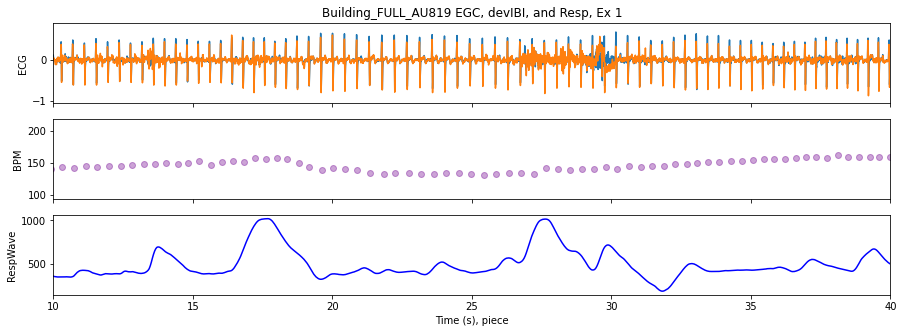

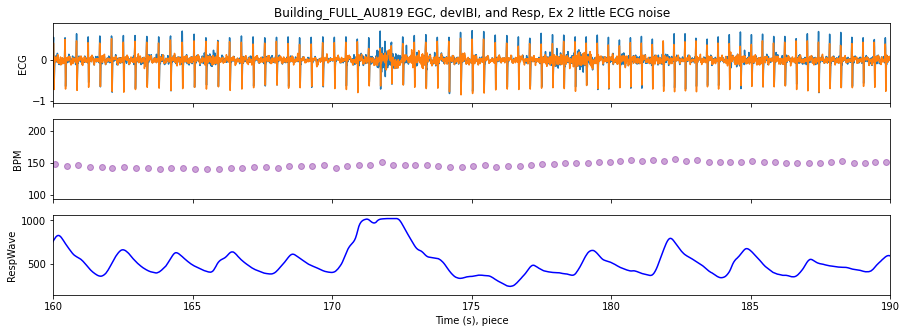

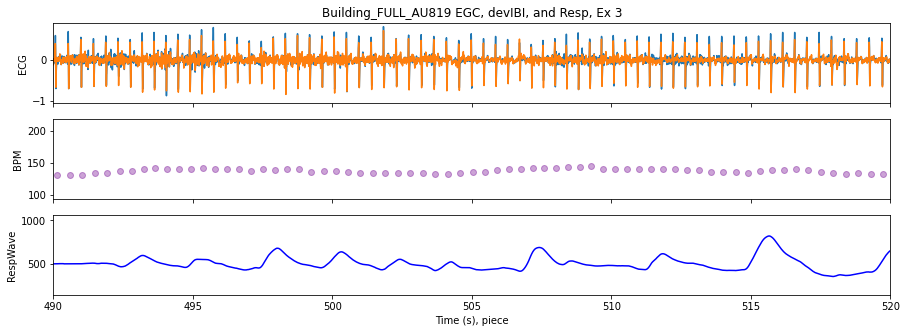

In [16]:
fig, (ax) = plt.subplots(3, 1,figsize = [15,5],sharex = True)
ax[1].scatter(x =sig_t,y=(60000/sig_v),color='r',alpha = 0.2,label='Single Beat')
ax[1].scatter(x = IBI.index,y = (60000/IBI['IBI']),color='b',alpha = 0.2,label='cleaned')
ax[1].set_ylabel('BPM')
ax[0].plot(C['p_sTime'],C[['Lead 1','Lead 2']],label='ECG')
ax[0].set_xlim([10,40])
ax[0].set_ylabel('ECG')
ax[2].plot(R['p_sTime'],R['Breathing'],color = 'b',label='Respiration')
ax[2].set_xlabel('Time (s), piece')
ax[2].set_ylabel('RespWave')
ax[0].set_title(sig_ex +' EGC, devIBI, and Resp, Ex 1')
plt.savefig(plot_loc+'_'.join([sig_ex,'Cardio','Resp','ex1'])+'.png',dpi=mydpi)

plt.show()

fig, (ax) = plt.subplots(3, 1,figsize = [15,5],sharex = True)
ax[1].scatter(x =sig_t,y=(60000/sig_v),color='r',alpha = 0.2,label='Single Beat')
ax[1].scatter(x = IBI.index,y = (60000/IBI['IBI']),color='b',alpha = 0.2,label='cleaned')
ax[1].set_ylabel('BPM')
ax[0].plot(C['p_sTime'],C[['Lead 1','Lead 2']],label='ECG')
ax[0].set_xlim([160,190])
ax[0].set_ylabel('ECG')
ax[2].plot(R['p_sTime'],R['Breathing'],color = 'b',label='Respiration')
ax[2].set_xlabel('Time (s), piece')
ax[2].set_ylabel('RespWave')
ax[0].set_title(sig_ex +' EGC, devIBI, and Resp, Ex 2 little ECG noise')
plt.savefig(plot_loc+'_'.join([sig_ex,'Cardio','Resp','ex2'])+'.png',dpi=mydpi)

plt.show()

fig, (ax) = plt.subplots(3, 1,figsize = [15,5],sharex = True)
ax[1].scatter(x =sig_t,y=(60000/sig_v),color='r',alpha = 0.2,label='Single Beat')
ax[1].scatter(x = IBI.index,y = (60000/IBI['IBI']),color='b',alpha = 0.2,label='cleaned')
ax[1].set_ylabel('BPM')
ax[0].plot(C['p_sTime'],C[['Lead 1','Lead 2']],label='ECG')
ax[0].set_xlim([490,520])
ax[0].set_ylabel('ECG')
ax[2].plot(R['p_sTime'],R['Breathing'],color = 'b',label='Respiration')
ax[2].set_xlabel('Time (s), piece')
ax[2].set_ylabel('RespWave')
ax[0].set_title(sig_ex +' EGC, devIBI, and Resp, Ex 3')
plt.savefig(plot_loc+'_'.join([sig_ex,'Cardio','Resp','ex3'])+'.png',dpi=mydpi)

plt.show()

In [707]:
plot_loc+'_'.join([sig_ex,'Cardio','Resp'])+'.png'

'./plots/C1_Arba_LS410_Cardio_Resp.png'

### Deviant heart beats

One example of noise in IBI signals that are routinely removed from Heart Rate and Heart Rate Variance measurements are true deviations of heat beats that are one off skips seamingly not related to local (10-20s) trajectory of cardiac features. 

In a recording from conductor, the IBIs extracted from the EQ 2 line ECG recordings are fairly clean and orderly but there are two skips of surprisingly short IBIs followed by a long IBI and then beats of a more steady character.  

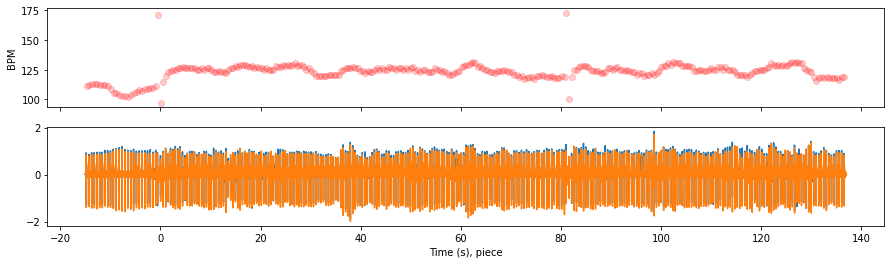

In [713]:
sig_ex = 'C5_Stra_PC707'
V = pd.read_csv(data_loc + sig_ex+'_EQCIBI.csv', index_col = 0)
sig_t = V['p_sTime']
sig_v = V['Interbeat Interval (MS)']
C = pd.read_csv(data_loc + sig_ex + '_EQ2ECG.csv', index_col = 0)

fig, (ax) = plt.subplots(2, 1,figsize = [15,4],sharex = True)
ax[0].scatter(x =sig_t,y=(60000/sig_v),color='r',alpha = 0.2,label='Single Beat')
ax[0].set_ylabel('BPM')
ax[1].plot(C['p_sTime'],C[['Lead 1','Lead 2']],label='ECG')
ax[1].set_xlabel('Time (s), piece')
# plt.savefig(plot_loc+'_'.join([sig_ex,'Cardio'])+'.png',dpi=mydpi)

plt.show()

The plot above shows the instantaneous heart rate above in red, IBI transformed into BPM for more easily read units, and the two line (blue and orange) ECG recordings (256 hz) from which beats were infered during the conducting on a piece of orchestral music. The two noise-like deviations are at the start (around 0 s) and 82 s into this piece of music. We can zoom into these moments to see what is happening in the ECG signal that might results in these big fluctuations in IBI. 

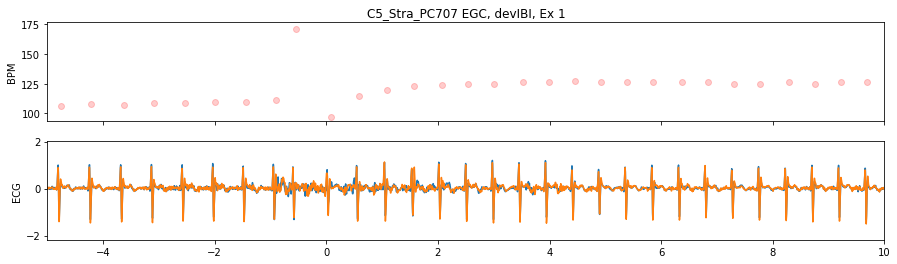

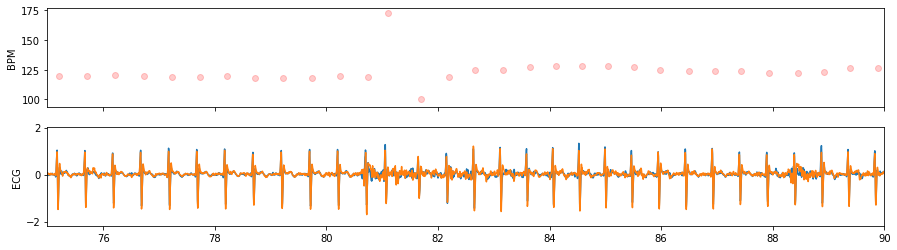

In [714]:
fig, (ax) = plt.subplots(2, 1,figsize = [15,4],sharex = True)
ax[0].scatter(x =sig_t,y=(60000/sig_v),color='r',alpha = 0.2,label='Single Beat')
ax[0].set_ylabel('BPM')
ax[1].plot(C['p_sTime'],C[['Lead 1','Lead 2']],label='ECG')
ax[1].set_xlim([-5,10])
ax[1].set_ylabel('ECG')
ax[0].set_title(sig_ex +' EGC, devIBI, Ex 1')
plt.savefig(plot_loc+'_'.join([sig_ex,'Cardio','ex1'])+'.png',dpi=mydpi)

plt.show()

fig, (ax) = plt.subplots(2, 1,figsize = [15,4],sharex = True)
ax[0].scatter(x =sig_t,y=(60000/sig_v),color='r',alpha = 0.2,label='Single Beat')
ax[0].set_ylabel('BPM')
ax[1].plot(C['p_sTime'],C[['Lead 1','Lead 2']],label='ECG')
ax[1].set_xlim([75,90])
ax[1].set_ylabel('ECG')

plt.show()

Example cleaning of these deviate beats, explicitly removing based on larger relative beat length compared to neighbours. Explicit calculation and then example of using defined clean_IBI function.

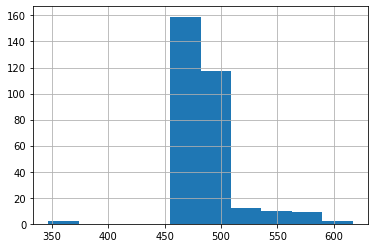

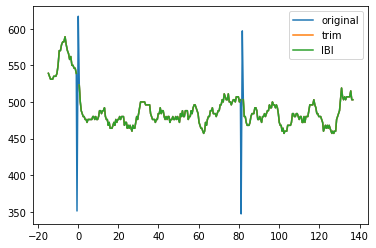

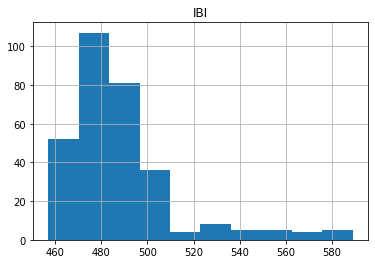

In [715]:
sig_ex = 'C5_Stra_PC707'
V = pd.read_csv(data_loc + sig_ex+'_EQCIBI.csv', index_col = 0)
sig_t = V['p_sTime']
sig_v = V['Interbeat Interval (MS)']
sig_v.hist()
plt.show()

plt.plot(sig_t,sig_v,label='original')
sig_v_pre = np.log2(sig_v/sig_v.shift(1)).abs()
sig_v_post = np.log2(sig_v.shift(-1)/sig_v).abs()
sig_v = sig_v.mask((sig_v_post>0.15) & (sig_v_pre>0.15))
plt.plot(sig_t,sig_v,label='trim')

IBI=clean_IBI(V['p_sTime'], V['Interbeat Interval (MS)'])
plt.plot(IBI.index,IBI['IBI'],label='IBI')
plt.legend()
plt.show()

IBI.hist()
plt.show()

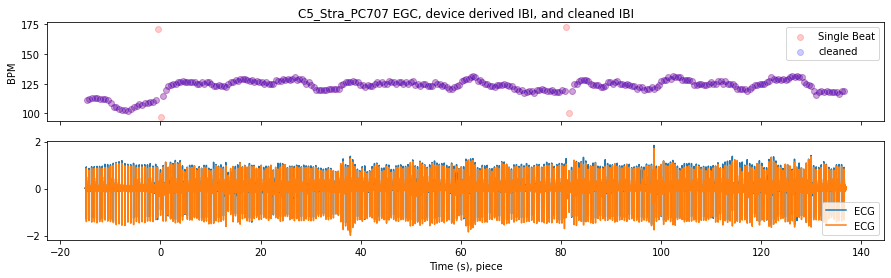

In [718]:
sig_ex = 'C5_Stra_PC707'
V = pd.read_csv(data_loc + sig_ex+'_EQCIBI.csv', index_col = 0)
sig_t = V['p_sTime']
sig_v = V['Interbeat Interval (MS)']
C = pd.read_csv(data_loc + sig_ex + '_EQ2ECG.csv', index_col = 0)
IBI=clean_IBI(sig_t,sig_v,activitytype='default')

fig, (ax) = plt.subplots(2, 1,figsize = [15,4],sharex = True)
ax[0].scatter(x =sig_t,y=(60000/sig_v),color='r',alpha = 0.2,label='Single Beat')
ax[0].scatter(x = IBI.index,y = (60000/IBI['IBI']),color='b',alpha = 0.2,label='cleaned')
ax[0].set_ylabel('BPM')
ax[1].plot(C['p_sTime'],C[['Lead 1','Lead 2']],label='ECG')
ax[1].set_xlabel('Time (s), piece')
ax[0].set_title(sig_ex +' EGC, device derived IBI, and cleaned IBI')
ax[0].legend()
ax[1].legend()
plt.savefig(plot_loc+'_'.join([sig_ex,'Cardio'])+'.png',dpi=mydpi)

plt.show()

In both of these moments, it looks like these deviations are genuinely reflecting the player's heart beat timing, with a clear electrical burst arring remarkably early, then followed by a longer beat and return to normal rates. 

Why this is happening, we can't say, but this kind of signal information is not typically part of HRV calculations or HR calculations, as the behaviour has little lasting effect on the trajectory of cardiac activity over time. There are many ways to cut these kinds of deviations from the features extracted. 

Below are the measurements from a participant with much more frequent deviant beats like this. Sometimes these deviations results in beats being skipped by the Equivital sensors' initial IBI assessment algorithm (example two below.) 

For HR and HRV assessments, such beat timing deviations need to be handled as outliers rather than significant distribution information related to the qualities we hope to investigate. 

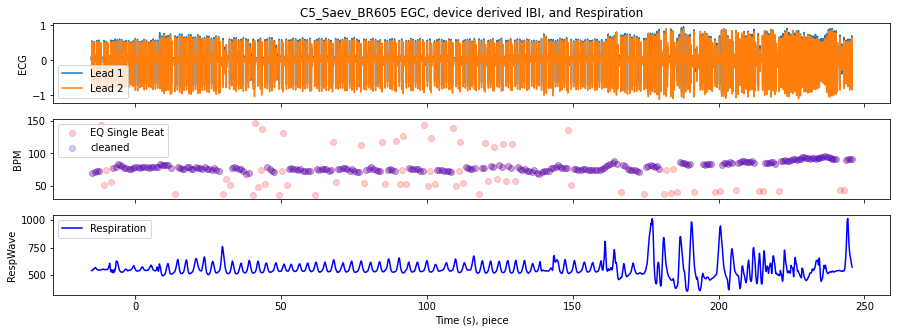

In [727]:
sig_ex = 'C5_Saev_BR605'
V = pd.read_csv(data_loc + sig_ex+'_EQCIBI.csv', index_col = 0)
sig_t = V['p_sTime']
sig_v = V['Interbeat Interval (MS)']
C = pd.read_csv(data_loc + sig_ex + '_EQ2ECG.csv', index_col = 0)
R = pd.read_csv(data_loc + sig_ex + '_EQRESP.csv', index_col = 0)

IBI=clean_IBI(sig_t,sig_v,activitytype='default')

fig, (ax) = plt.subplots(3, 1,figsize = [15,5],sharex = True)
ax[1].scatter(x =sig_t,y=(60000/sig_v),color='r',alpha = 0.2,label='EQ Single Beat')
ax[1].scatter(x = IBI.index,y = (60000/IBI['IBI']),color='b',alpha = 0.2,label='cleaned')
ax[1].set_ylabel('BPM')
ax[0].plot(C['p_sTime'],C[['Lead 1','Lead 2']],label=['Lead 1','Lead 2'])
ax[0].set_ylabel('ECG')
ax[2].plot(R['p_sTime'],R['Breathing'],color = 'b',label='Respiration')
ax[2].set_xlabel('Time (s), piece')
ax[2].set_ylabel('RespWave')
ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[0].set_title(sig_ex +' EGC, device derived IBI, and Respiration')
plt.savefig(plot_loc+'_'.join([sig_ex,'Cardio','Resp'])+'.png',dpi=mydpi)

plt.show()

Looking at the respiration signal, we can see when this brass player shifted from tacet to playing, after 150s into this piece of music. The ECG signal also becomes wider and more variable during playing. The annomalous beats (according to this IBI cleaning function) occure both during tacet (not playing) and during play, so it is unlikely that this the results of some kind of performance motion artifact at the sensor level. A closer looks is needed.

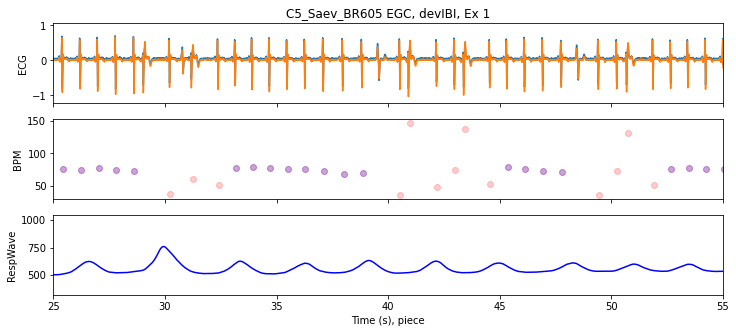

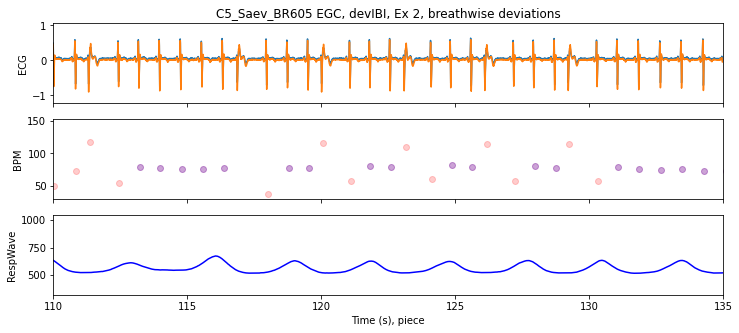

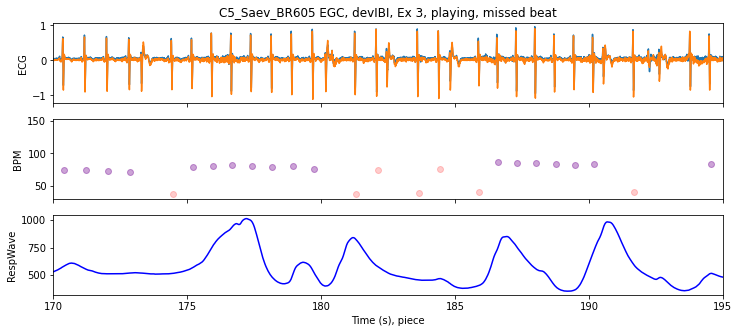

In [728]:
fig, (ax) = plt.subplots(3, 1,figsize = [12,5],sharex = True)
ax[1].scatter(x =sig_t,y=(60000/sig_v),color='r',alpha = 0.2,label='Single Beat')
ax[1].scatter(x = IBI.index,y = (60000/IBI['IBI']),color='b',alpha = 0.2,label='cleaned')
ax[1].set_ylabel('BPM')
ax[0].plot(C['p_sTime'],C[['Lead 1','Lead 2']])
ax[0].set_ylabel('ECG')
ax[2].plot(R['p_sTime'],R['Breathing'],color = 'b',label='Respiration')
ax[2].set_xlabel('Time (s), piece')
ax[2].set_ylabel('RespWave')
ax[0].set_title(sig_ex +' EGC, devIBI, Ex 1')
ax[0].set_xlim([25,55])
plt.savefig(plot_loc+'_'.join([sig_ex,'Cardio','ex1'])+'.png',dpi=mydpi)
plt.show()

fig, (ax) = plt.subplots(3, 1,figsize = [12,5],sharex = True)
ax[1].scatter(x =sig_t,y=(60000/sig_v),color='r',alpha = 0.2,label='Single Beat')
ax[1].scatter(x = IBI.index,y = (60000/IBI['IBI']),color='b',alpha = 0.2,label='cleaned')
ax[1].set_ylabel('BPM')
ax[0].plot(C['p_sTime'],C[['Lead 1','Lead 2']])
ax[0].set_ylabel('ECG')
ax[1].set_xlim([110,135])
ax[2].plot(R['p_sTime'],R['Breathing'],color = 'b',label='Respiration')
ax[2].set_xlabel('Time (s), piece')
ax[2].set_ylabel('RespWave')
ax[0].set_title(sig_ex +' EGC, devIBI, Ex 2, breathwise deviations')
plt.savefig(plot_loc+'_'.join([sig_ex,'Cardio','ex2'])+'.png',dpi=mydpi)
plt.show()

fig, (ax) = plt.subplots(3, 1,figsize = [12,5],sharex = True)
ax[1].scatter(x =sig_t,y=(60000/sig_v),color='r',alpha = 0.2,label='Single Beat')
ax[1].scatter(x = IBI.index,y = (60000/IBI['IBI']),color='b',alpha = 0.2,label='cleaned')
ax[1].set_ylabel('BPM')
ax[0].plot(C['p_sTime'],C[['Lead 1','Lead 2']])
ax[0].set_ylabel('ECG')
ax[1].set_xlim([170,195])
ax[2].plot(R['p_sTime'],R['Breathing'],color = 'b',label='Respiration')
ax[2].set_xlabel('Time (s), piece')
ax[2].set_ylabel('RespWave')
ax[0].set_title(sig_ex +' EGC, devIBI, Ex 3, playing, missed beat')
plt.savefig(plot_loc+'_'.join([sig_ex,'Cardio','ex3'])+'.png',dpi=mydpi)
plt.show()

All of these instances of annomalous IBIs are from true beat deviations, rather than sensor noise. However, some of these deviations are so dramatic that the Equivital sensor algorithm automatically excludes some of these shorted intervals (see Ex 3). In all of these cases, this kind of cardiac IBI deviation is still in a different categories of variability than we are looking to evaluate, and so they are excluded by the IBI cleaning algorithm for the sake of some features. 

### Sensor noise deviations
In on ther measurements, sudden HR deviations are the result of sensor noise confusing the IBI extraction algorithm, like in this recording of heart rate from a brass player during Clapping Music.

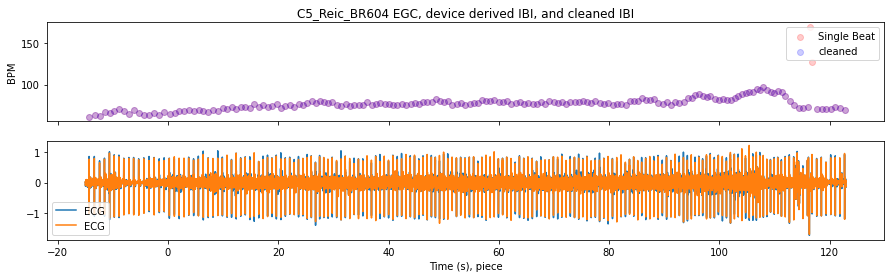

In [723]:
sig_ex = 'C5_Reic_BR604'
V = pd.read_csv(data_loc + sig_ex+'_EQCIBI.csv', index_col = 0)
sig_t = V['p_sTime']
sig_v = V['Interbeat Interval (MS)']
C = pd.read_csv(data_loc + sig_ex + '_EQ2ECG.csv', index_col = 0)
IBI=clean_IBI(sig_t,sig_v,activitytype='default')

fig, (ax) = plt.subplots(2, 1,figsize = [15,4],sharex = True)
ax[0].scatter(x =sig_t,y=(60000/sig_v),color='r',alpha = 0.2,label='Single Beat')
ax[0].scatter(x = IBI.index,y = (60000/IBI['IBI']),color='b',alpha = 0.2,label='cleaned')
ax[0].set_ylabel('BPM')
ax[1].plot(C['p_sTime'],C[['Lead 1','Lead 2']],label='ECG')
ax[1].set_xlabel('Time (s), piece')
ax[0].set_title(sig_ex +' EGC, device derived IBI, and cleaned IBI')
ax[0].legend()
ax[1].legend()
plt.savefig(plot_loc+'_'.join([sig_ex,'Cardio'])+'.png',dpi=mydpi)

plt.show()

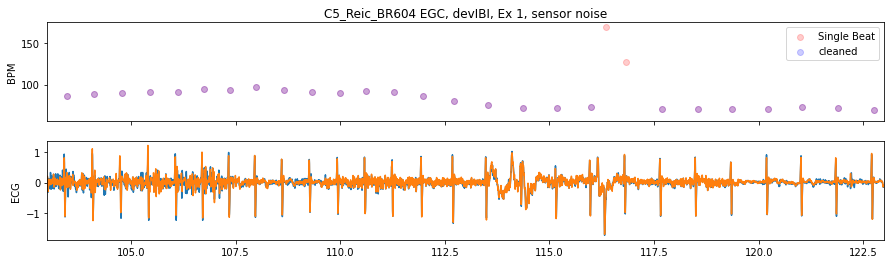

In [725]:
fig, (ax) = plt.subplots(2, 1,figsize = [15,4],sharex = True)
ax[1].scatter(x =sig_t,y=(60000/sig_v),color='r',alpha = 0.2,label='Single Beat')
ax[1].scatter(x = IBI.index,y = (60000/IBI['IBI']),color='b',alpha = 0.2,label='cleaned')
ax[1].legend()
ax[1].set_ylabel('BPM')
ax[0].plot(C['p_sTime'],C[['Lead 1','Lead 2']],label='ECG')
ax[0].set_xlim([103,123])
ax[0].set_ylabel('ECG')
ax[0].set_title(sig_ex +' EGC, devIBI, Ex 1, sensor noise')
plt.savefig(plot_loc+'_'.join([sig_ex,'Cardio','ex1'])+'.png',dpi=mydpi)


Again, we don't know exactly why there is a weird extra activity in the ECG recording but in this case it is most appropriate to cut what looks like a beat falsely detected between two others, resulting in a sudden spike in HR values when the true cardiac activty was more steady. 

### Surprise deviations in wide swinging heart rates

Some people, and some players, show a lot of natural variation in their heart rates, making noise handling a bit more difficult. This measurements of a bassoonist has what looks like natural swings of heart rate doubling within intervals of 30 s, but also a lot of potential moments of noise. 

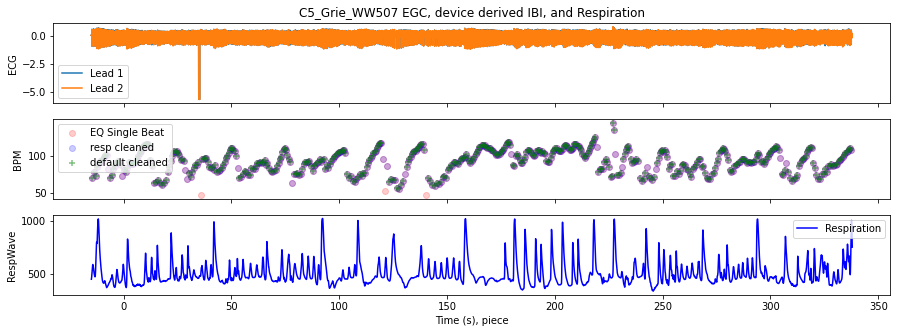

In [731]:
sig_ex = 'C5_Grie_WW507'
V = pd.read_csv(data_loc + sig_ex+'_EQCIBI.csv', index_col = 0)
sig_t = V['p_sTime']
sig_v = V['Interbeat Interval (MS)']
C = pd.read_csv(data_loc + sig_ex + '_EQ2ECG.csv', index_col = 0)
R = pd.read_csv(data_loc + sig_ex + '_EQRESP.csv', index_col = 0)

IBI=clean_IBI(sig_t,sig_v,activitytype='resp')
IBI_o=clean_IBI(sig_t,sig_v,activitytype='default')


fig, (ax) = plt.subplots(3, 1,figsize = [15,5],sharex = True)
ax[1].scatter(x =sig_t,y=(60000/sig_v),color='r',alpha = 0.2,label='EQ Single Beat')
ax[1].scatter(x = IBI.index,y = (60000/IBI['IBI']),color='b',alpha = 0.2,label='resp cleaned')
ax[1].scatter(x = IBI_o.index,y = (60000/IBI_o['IBI']),color='g',marker = '+',alpha = 0.5,label='default cleaned')
ax[1].set_ylabel('BPM')
ax[0].plot(C['p_sTime'],C[['Lead 1','Lead 2']],label=['Lead 1','Lead 2'])
ax[0].set_ylabel('ECG')
ax[2].plot(R['p_sTime'],R['Breathing'],color = 'b',label='Respiration')
ax[2].set_xlabel('Time (s), piece')
ax[2].set_ylabel('RespWave')
ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[0].set_title(sig_ex +' EGC, device derived IBI, and Respiration')
plt.savefig(plot_loc+'_'.join([sig_ex,'Cardio','Resp'])+'.png',dpi=mydpi)

plt.show()

This windplayer shows very wide swings of heart rate that seem characteristic of the playing actions, namely with the longer breaths through some phrases. In order to avoid accidentally cutting musically relevant IBIs, the exclusion criteria is loosed for IBI_clean with the activitytype set to 'resp' meaning respiratory sound production. 

A closer look at some excerpts show still another kind of sensor error and the context for the remaining excluded beats.

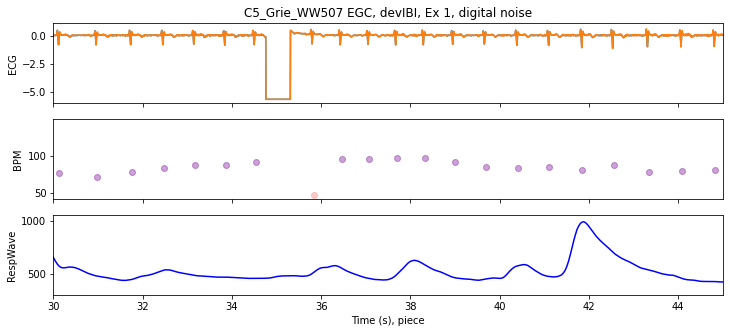

In [732]:
fig, (ax) = plt.subplots(3, 1,figsize = [12,5],sharex = True)
ax[1].scatter(x =sig_t,y=(60000/sig_v),color='r',alpha = 0.2,label='Single Beat')
ax[1].scatter(x = IBI.index,y = (60000/IBI['IBI']),color='b',alpha = 0.2,label='cleaned')
ax[1].set_ylabel('BPM')
ax[0].plot(C['p_sTime'],C[['Lead 1','Lead 2']])
ax[0].set_ylabel('ECG')
ax[2].plot(R['p_sTime'],R['Breathing'],color = 'b',label='Respiration')
ax[2].set_xlabel('Time (s), piece')
ax[2].set_ylabel('RespWave')
ax[0].set_title(sig_ex +' EGC, devIBI, Ex 1, digital noise')
ax[1].set_xlim([30,45])
plt.savefig(plot_loc+'_'.join([sig_ex,'Cardio','ex1'])+'.png',dpi=mydpi)
plt.show()


Here the ECG signal lost signal completely, just for long enough to miss a heart beat and resulting in a falsely long beat infered by EQ and necessarily excluded by the IBI_cleaning function. This can be the results of EM interference with the cables, or some kind of isolated malfunction of the sensory vest. It only happens once in this interval, thankfully.

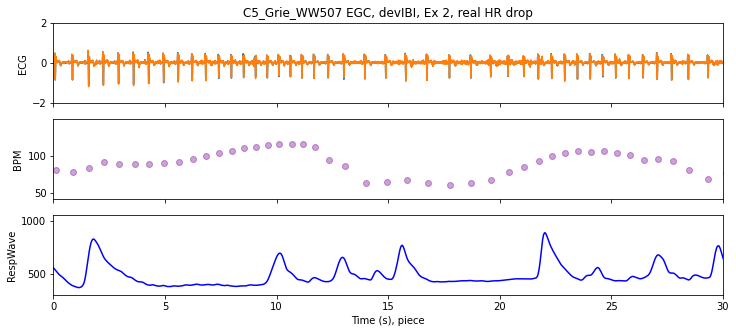

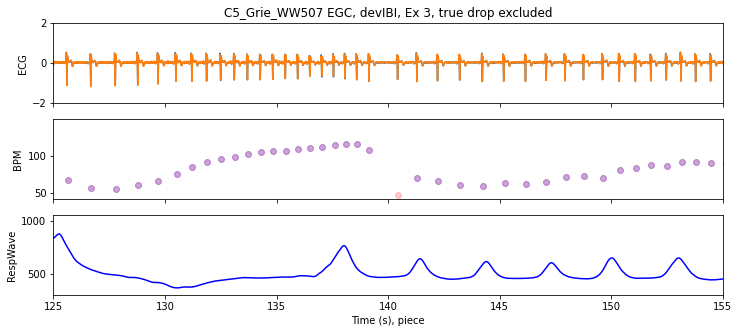

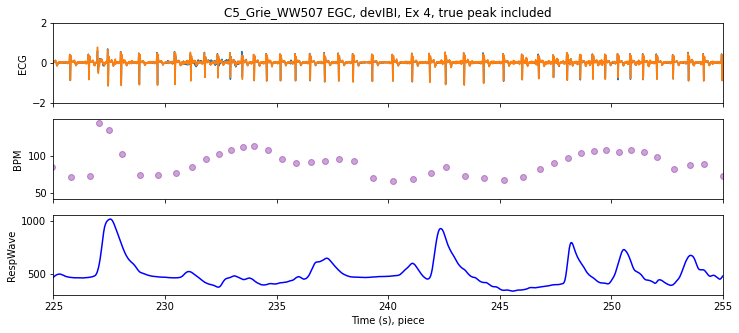

In [734]:
fig, (ax) = plt.subplots(3, 1,figsize = [12,5],sharex = True)
ax[1].scatter(x =sig_t,y=(60000/sig_v),color='r',alpha = 0.2,label='Single Beat')
ax[1].scatter(x = IBI.index,y = (60000/IBI['IBI']),color='b',alpha = 0.2,label='cleaned')
ax[1].set_ylabel('BPM')
ax[0].plot(C['p_sTime'],C[['Lead 1','Lead 2']])
ax[0].set_ylabel('ECG')
ax[0].set_ylim([-2,2])
ax[2].plot(R['p_sTime'],R['Breathing'],color = 'b',label='Respiration')
ax[2].set_xlabel('Time (s), piece')
ax[2].set_ylabel('RespWave')
ax[0].set_title(sig_ex +' EGC, devIBI, Ex 2, real HR drop')
ax[1].set_xlim([0,30])
plt.savefig(plot_loc+'_'.join([sig_ex,'Cardio','resp','ex2'])+'.png',dpi=mydpi)
plt.show()

fig, (ax) = plt.subplots(3, 1,figsize = [12,5],sharex = True)
ax[1].scatter(x =sig_t,y=(60000/sig_v),color='r',alpha = 0.2,label='Single Beat')
ax[1].scatter(x = IBI.index,y = (60000/IBI['IBI']),color='b',alpha = 0.2,label='cleaned')
ax[1].set_ylabel('BPM')
ax[0].plot(C['p_sTime'],C[['Lead 1','Lead 2']])
ax[0].set_ylabel('ECG')
ax[0].set_ylim([-2,2])
ax[2].plot(R['p_sTime'],R['Breathing'],color = 'b',label='Respiration')
ax[2].set_xlabel('Time (s), piece')
ax[2].set_ylabel('RespWave')
ax[0].set_title(sig_ex +' EGC, devIBI, Ex 3, true drop excluded')
ax[1].set_xlim([125,155])
plt.savefig(plot_loc+'_'.join([sig_ex,'Cardio','resp','ex3'])+'.png',dpi=mydpi)
plt.show()


fig, (ax) = plt.subplots(3, 1,figsize = [12,5],sharex = True)
ax[1].scatter(x =sig_t,y=(60000/sig_v),color='r',alpha = 0.2,label='Single Beat')
ax[1].scatter(x = IBI.index,y = (60000/IBI['IBI']),color='b',alpha = 0.2,label='cleaned')
ax[1].set_ylabel('BPM')
ax[0].plot(C['p_sTime'],C[['Lead 1','Lead 2']])
ax[0].set_ylabel('ECG')
ax[0].set_ylim([-2,2])
ax[2].plot(R['p_sTime'],R['Breathing'],color = 'b',label='Respiration')
ax[2].set_xlabel('Time (s), piece')
ax[2].set_ylabel('RespWave')
ax[1].set_xlim([225,255])
ax[0].set_title(sig_ex +' EGC, devIBI, Ex 4, true peak included')
plt.savefig(plot_loc+'_'.join([sig_ex,'Cardio','resp','ex4'])+'.png',dpi=mydpi)
plt.show()

For this player, the big swings in beat duration are accurate beat measurements, reflecting the direct effect of wind players' extraordinary respiratory activity on cardiac rhythms. These examples demonstrate how the IBI_cleaning algorithm handles sudden changes. The excluded drop (Ex 3) is missed because  outlier beat is extremly different in IBI ratios both preceeding and following. the included peak (Ex 4) is kept because that IBI is close to that of beats following, even if the ratio is very different from what was before. 

### Heavy sensor noise
There are also instances where the sensor noise confuses the device IBI estimates. This is usually noticeable in the ECG signals when investigated directly, so it is worth checking these closely before trusting what the IBI_cleaning function derives on a messy measurement.

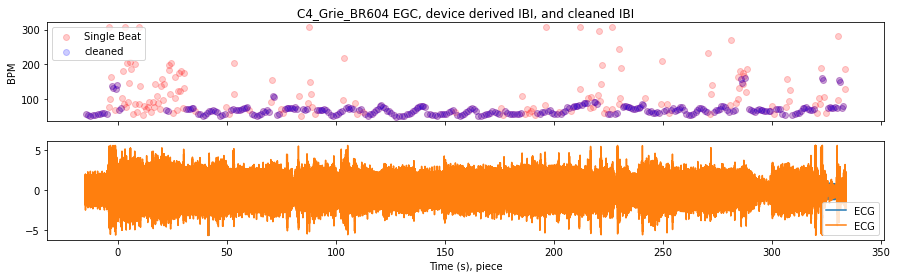

In [735]:
sig_ex = 'C4_Grie_BR604'
V = pd.read_csv(data_loc + sig_ex+'_EQCIBI.csv', index_col = 0)
sig_t = V['p_sTime']
sig_v = V['Interbeat Interval (MS)']
C = pd.read_csv(data_loc + sig_ex + '_EQ2ECG.csv', index_col = 0)
IBI=clean_IBI(sig_t,sig_v,activitytype='default')

fig, (ax) = plt.subplots(2, 1,figsize = [15,4],sharex = True)
ax[0].scatter(x =sig_t,y=(60000/sig_v),color='r',alpha = 0.2,label='Single Beat')
ax[0].scatter(x = IBI.index,y = (60000/IBI['IBI']),color='b',alpha = 0.2,label='cleaned')
ax[0].set_ylabel('BPM')
ax[1].plot(C['p_sTime'],C[['Lead 1','Lead 2']],label='ECG')
ax[1].set_xlabel('Time (s), piece')
ax[0].set_title(sig_ex +' EGC, device derived IBI, and cleaned IBI')
ax[0].legend()
ax[1].legend()
plt.savefig(plot_loc+'_'.join([sig_ex,'Cardio'])+'.png',dpi=mydpi)

plt.show()

Still there are some instances of noise in this signal, such as a signal drop.

This kind of noise is just a sensor error, some kind of digital signal glitch resulting in a beat lost and a false slow one recorded by the IBI extraction algorithm. 

This IBI signal is obviously a mess. No human adult has a heart rate of 300 BMP, 200 BPM would be extraordinary for any playing music on stage. The cleaning IBIs follow shapes that look reasonable except for the spurts of noise that go way above what is conceivable.

The second thing to notice is that the ECG signal doesn't look like an ECG signal at all. Here one of the two leads (Lead 2) was not functioning properly. Luckily, the first lead did work. We will plot them in reverse order to show what is in the signals as these particularly messy moments.

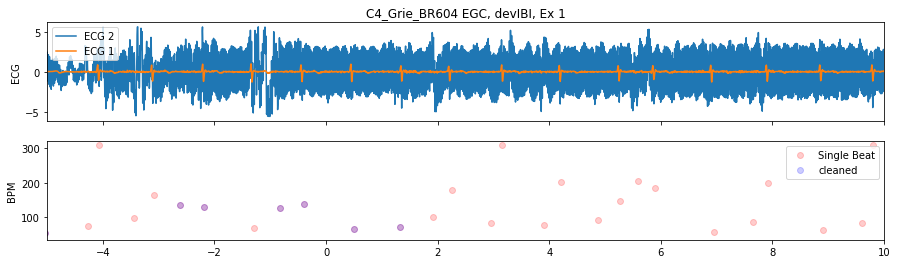

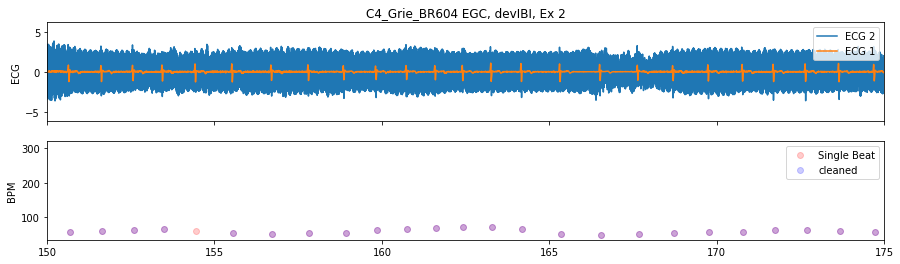

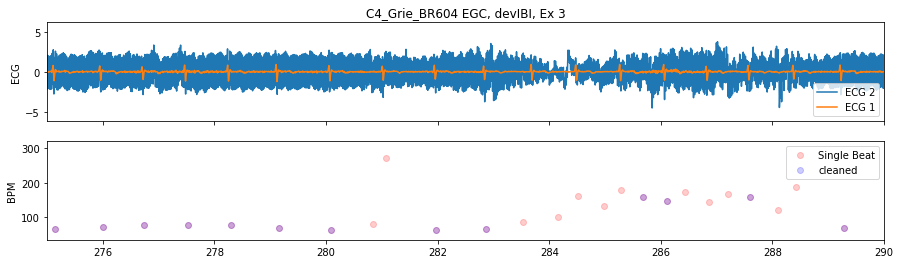

In [736]:
fig, (ax) = plt.subplots(2, 1,figsize = [15,4],sharex = True)
ax[1].scatter(x =sig_t,y=(60000/sig_v),color='r',alpha = 0.2,label='Single Beat')
ax[1].scatter(x = IBI.index,y = (60000/IBI['IBI']),color='b',alpha = 0.2,label='cleaned')
ax[1].legend()
ax[1].set_ylabel('BPM')
ax[0].plot(C['p_sTime'],C['Lead 2'],label='ECG 2')
ax[0].plot(C['p_sTime'],C['Lead 1'],label='ECG 1')
ax[1].set_xlim([-5,10])
ax[0].set_ylabel('ECG')
ax[0].legend()
ax[0].set_title(sig_ex +' EGC, devIBI, Ex 1')
plt.savefig(plot_loc+'_'.join([sig_ex,'Cardio','ex1'])+'.png',dpi=mydpi)
plt.show()

fig, (ax) = plt.subplots(2, 1,figsize = [15,4],sharex = True)
ax[1].scatter(x =sig_t,y=(60000/sig_v),color='r',alpha = 0.2,label='Single Beat')
ax[1].scatter(x = IBI.index,y = (60000/IBI['IBI']),color='b',alpha = 0.2,label='cleaned')
ax[1].legend()
ax[1].set_ylabel('BPM')
ax[0].plot(C['p_sTime'],C['Lead 2'],label='ECG 2')
ax[0].plot(C['p_sTime'],C['Lead 1'],label='ECG 1')
ax[1].set_xlim([150,175])
ax[0].set_ylabel('ECG')
ax[0].legend()
ax[0].set_title(sig_ex +' EGC, devIBI, Ex 2')
plt.savefig(plot_loc+'_'.join([sig_ex,'Cardio','ex2'])+'.png',dpi=mydpi)
plt.show()

fig, (ax) = plt.subplots(2, 1,figsize = [15,4],sharex = True)
ax[1].scatter(x =sig_t,y=(60000/sig_v),color='r',alpha = 0.2,label='Single Beat')
ax[1].scatter(x = IBI.index,y = (60000/IBI['IBI']),color='b',alpha = 0.2,label='cleaned')
ax[1].legend()
ax[1].set_ylabel('BPM')
ax[0].plot(C['p_sTime'],C['Lead 2'],label='ECG 2')
ax[0].plot(C['p_sTime'],C['Lead 1'],label='ECG 1')
ax[1].set_xlim([275,290])
ax[0].set_ylabel('ECG')
ax[0].legend()
ax[0].set_title(sig_ex +' EGC, devIBI, Ex 3')
plt.savefig(plot_loc+'_'.join([sig_ex,'Cardio','ex3'])+'.png',dpi=mydpi)
plt.show()

As the Equivital algorithm tried to find signal between both line 1 and line 2, some times the IBIs are accurate and sometimes they are not. In this case, the IBI file should be reassessed using only Line 1 electrod measurements (above in orange). 

Note: This same combination of vest and SEM on the same performer yeilded clean measurements on other days, so we can assume this is a problem with how the vest was worn. Either something was preventing contact for one electrode or one of the vest clasps was left loose. 

### Extracting IBI from ECG
From sensors without IBI outputs (Movesense) or bad algorithm performance on IBI (Equivitals), we can try to replace the IBI file by reprocessing the ECG, rather than just filtering out beats that could be noise. 

I've been using heartpy for this kind of signal processing.

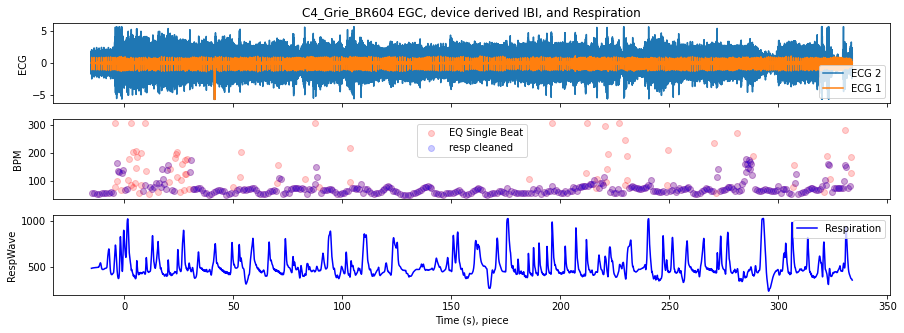

In [739]:
sig_ex = 'C4_Grie_BR604'
V = pd.read_csv(data_loc + sig_ex+'_EQCIBI.csv', index_col = 0)
sig_t = V['p_sTime']
sig_v = V['Interbeat Interval (MS)']
C = pd.read_csv(data_loc + sig_ex + '_EQ2ECG.csv', index_col = 0)
R = pd.read_csv(data_loc + sig_ex + '_EQRESP.csv', index_col = 0)

IBI=clean_IBI(sig_t,sig_v,activitytype='resp')

fig, (ax) = plt.subplots(3, 1,figsize = [15,5],sharex = True)
ax[1].scatter(x =sig_t,y=(60000/sig_v),color='r',alpha = 0.2,label='EQ Single Beat')
ax[1].scatter(x = IBI.index,y = (60000/IBI['IBI']),color='b',alpha = 0.2,label='resp cleaned')
ax[1].set_ylabel('BPM')
ax[0].plot(C['p_sTime'],C['Lead 2'],label='ECG 2')
ax[0].plot(C['p_sTime'],C['Lead 1'],label='ECG 1')
ax[0].set_ylabel('ECG')
ax[2].plot(R['p_sTime'],R['Breathing'],color = 'b',label='Respiration')
ax[2].set_xlabel('Time (s), piece')
ax[2].set_ylabel('RespWave')
ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[0].set_title(sig_ex +' EGC, device derived IBI, and Respiration')
plt.savefig(plot_loc+'_'.join([sig_ex,'Cardio','Resp'])+'.png',dpi=mydpi)

plt.show()

In [738]:
sig = C.loc[:,'Lead 1'].values
sample_rate = 256# Hz
filtered = hp.filter_signal(sig, cutoff = 0.05, sample_rate = sample_rate, filtertype='notch')
wd, m = hp.process(hp.scale_data(filtered), sample_rate)

# IBIs by heartpy's better IBI list 
better_peak_index = wd['peaklist'][wd['binary_peaklist']==1]
IBIs = pd.DataFrame(columns = ['c_sTime','p_sTime','Interbeat Interval (MS)','rec_dTime','dev_dTime'])
IBIs[['c_sTime','p_sTime','rec_dTime','dev_dTime']] = C.loc[better_peak_index,['c_sTime','p_sTime','rec_dTime','dev_dTime']]
IBIs.iloc[1:,2] = wd['RR_list'][wd['binary_peaklist'][1:]==1].astype('int')

# IBIs by the IBI cleaning algo above, loosened parameters for respiration
br_t = np.linspace(C['p_sTime'].iloc[0],C['p_sTime'].iloc[-1],len(wd['breathing_signal']))
IBI=clean_IBI(list(C.loc[wd['peaklist'],'p_sTime'].values),None,activitytype='resp')

IBIs.iloc[:5,:]

,c_sTime,p_sTime,Interbeat Interval (MS),rec_dTime,dev_dTime
318,1579.214,-13.755,NaN,2023-02-17 10:42:46.102000+00:00,2023-02-17 10:42:45.738000+00:00
615,1580.374,-12.595,1160,2023-02-17 10:42:47.262000+00:00,2023-02-17 10:42:46.898000+00:00
908,1581.518,-11.451,1144,2023-02-17 10:42:48.406000+00:00,2023-02-17 10:42:48.042000+00:00
1188,1582.612,-10.357,1093,2023-02-17 10:42:49.500000+00:00,2023-02-17 10:42:49.136000+00:00
1465,1583.695,-9.274,1082,2023-02-17 10:42:50.583000+00:00,2023-02-17 10:42:50.218000+00:00


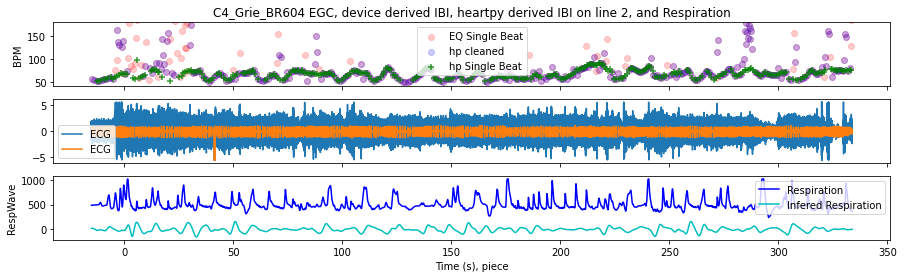

In [740]:

fig, (ax) = plt.subplots(3, 1,figsize = [15,4],sharex = True)
ax[0].scatter(x =sig_t,y=(60000/sig_v),color='r',alpha = 0.2,label='EQ Single Beat')
ax[0].scatter(x = IBI.index,y = (60000/IBI['IBI']),color='b',alpha = 0.2,label='hp cleaned')
ax[0].scatter(x =IBIs['p_sTime'],y=(60000/IBIs['Interbeat Interval (MS)']),color='g',marker='+',alpha = 0.8,label='hp Single Beat')
ax[0].set_ylim([40,180])
ax[0].set_ylabel('BPM')
ax[1].plot(C['p_sTime'],C['Lead 2'],label='ECG')
ax[1].plot(C['p_sTime'],C['Lead 1'],label='ECG')
ax[2].plot(R['p_sTime'],R['Breathing'],color = 'b',label='Respiration')
ax[2].plot(br_t,wd['breathing_signal'],color = 'c',label='Infered Respiration')
ax[2].set_xlabel('Time (s), piece')
ax[2].set_ylabel('RespWave')
ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[0].set_title(sig_ex +' EGC, device derived IBI, heartpy derived IBI on line 2, and Respiration')
plt.savefig(plot_loc+'_'.join([sig_ex,'hpCardio','hpResp'])+'.png',dpi=mydpi)

plt.show()

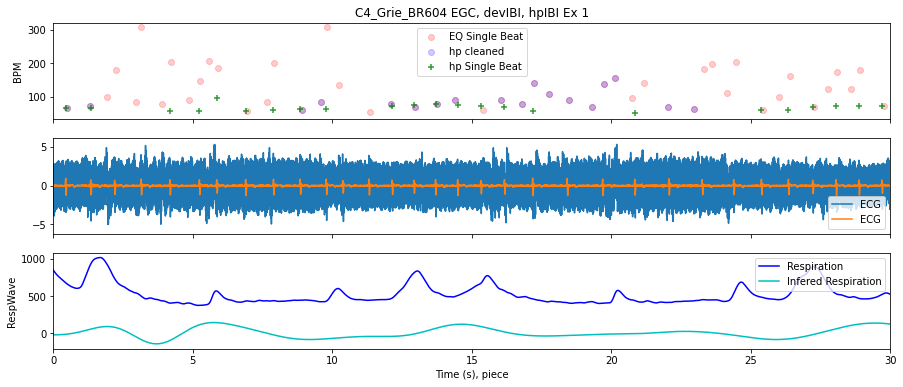

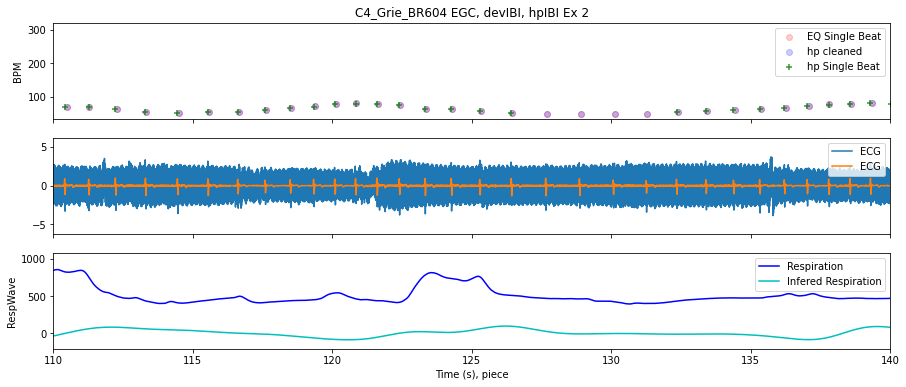

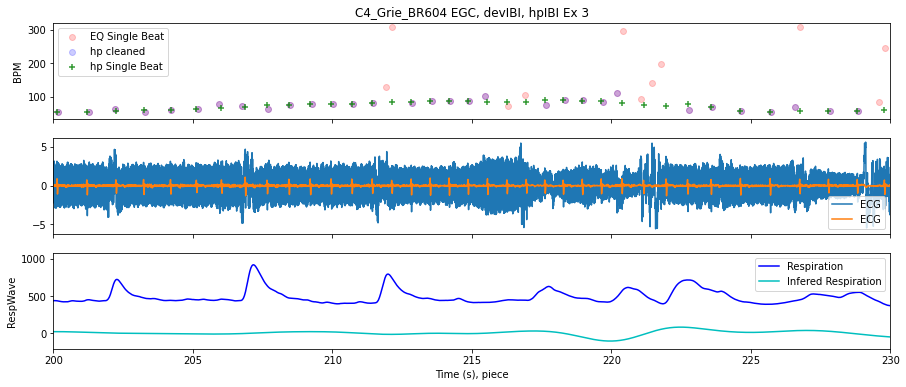

In [742]:
fig, (ax) = plt.subplots(3, 1,figsize = [15,6],sharex = True)
ax[0].scatter(x =sig_t,y=(60000/sig_v),color='r',alpha = 0.2,label='EQ Single Beat')
ax[0].scatter(x = IBI.index,y = (60000/IBI['IBI']),color='b',alpha = 0.2,label='hp cleaned')
ax[0].scatter(x =IBIs['p_sTime'],y=(60000/IBIs['Interbeat Interval (MS)']),color='g',marker='+',alpha = 0.8,label='hp Single Beat')
ax[0].set_ylabel('BPM')
ax[1].set_xlim([0,30])
ax[1].plot(C['p_sTime'],C['Lead 2'],label='ECG')
ax[1].plot(C['p_sTime'],C['Lead 1'],label='ECG')
ax[2].plot(R['p_sTime'],R['Breathing'],color = 'b',label='Respiration')
ax[2].plot(br_t,wd['breathing_signal'],color = 'c',label='Infered Respiration')
ax[2].set_xlabel('Time (s), piece')
ax[2].set_ylabel('RespWave')
ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[0].set_title(sig_ex +' EGC, devIBI, hpIBI Ex 1')
plt.savefig(plot_loc+'_'.join([sig_ex,'hpCardio','resp','ex1'])+'.png',dpi=mydpi)

plt.show()


fig, (ax) = plt.subplots(3, 1,figsize = [15,6],sharex = True)
ax[0].scatter(x =sig_t,y=(60000/sig_v),color='r',alpha = 0.2,label='EQ Single Beat')
ax[0].scatter(x = IBI.index,y = (60000/IBI['IBI']),color='b',alpha = 0.2,label='hp cleaned')
ax[0].scatter(x =IBIs['p_sTime'],y=(60000/IBIs['Interbeat Interval (MS)']),color='g',marker='+',alpha = 0.8,label='hp Single Beat')
ax[0].set_ylabel('BPM')
ax[1].set_xlim([110,140])
ax[1].plot(C['p_sTime'],C['Lead 2'],label='ECG')
ax[1].plot(C['p_sTime'],C['Lead 1'],label='ECG')
ax[2].plot(R['p_sTime'],R['Breathing'],color = 'b',label='Respiration')
ax[2].plot(br_t,wd['breathing_signal'],color = 'c',label='Infered Respiration')
ax[2].set_xlabel('Time (s), piece')
ax[2].set_ylabel('RespWave')
ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[0].set_title(sig_ex +' EGC, devIBI, hpIBI Ex 2')
plt.savefig(plot_loc+'_'.join([sig_ex,'hpCardio','resp','ex2'])+'.png',dpi=mydpi)

plt.show()

fig, (ax) = plt.subplots(3, 1,figsize = [15,6],sharex = True)
ax[0].scatter(x =sig_t,y=(60000/sig_v),color='r',alpha = 0.2,label='EQ Single Beat')
ax[0].scatter(x = IBI.index,y = (60000/IBI['IBI']),color='b',alpha = 0.2,label='hp cleaned')
ax[0].scatter(x =IBIs['p_sTime'],y=(60000/IBIs['Interbeat Interval (MS)']),color='g',marker='+',alpha = 0.8,label='hp Single Beat')
ax[0].set_ylabel('BPM')
ax[1].set_xlim([200,230])
ax[1].plot(C['p_sTime'],C['Lead 2'],label='ECG')
ax[1].plot(C['p_sTime'],C['Lead 1'],label='ECG')
ax[2].plot(R['p_sTime'],R['Breathing'],color = 'b',label='Respiration')
ax[2].plot(br_t,wd['breathing_signal'],color = 'c',label='Infered Respiration')
ax[2].set_xlabel('Time (s), piece')
ax[2].set_ylabel('RespWave')
ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[0].set_title(sig_ex +' EGC, devIBI, hpIBI Ex 3')
plt.savefig(plot_loc+'_'.join([sig_ex,'hpCardio','resp','ex3'])+'.png',dpi=mydpi)
plt.show()

Here we are using the beats as deamed retainable according to heartpy's automated inclusion criteria. This is more stringent than we might always like: in the first excerpt here we see a number of beats are missing that maybe should have been counted. And yet it is still a marked improvement from the noise of the initial EQ extracted IBIs with the confusion from Line2. 

Particularly for wind players, the algorithms for cleaning IBIs may need to be relaxes a bit for the genuine rapid changes in heart rate we see during their playing. This is covered in the following sections. The hp cleaned series here are the results of replacing heartpy's standard criteria for filtering beats with that of IBI_clean function above. Neither automatic algorithm is perfect, but there are circumstances were one approach may be more relevant than the other. 

Just for fun, I have also ploted here the inferred respiratory wave according to the heartpy evaluation, ploted against the measured respiration wave for this brass player in this excerpt. The infered wave does not seem meaningfully comparable to the actual respiratory action, however this may be due to the extreme respiratory behaviour being performed, outside of what the algorithm might be tuned to capture. Still its a good reminder of how this signal is not easily or reliably measured from cardiac activity alone. 

# Local Heart Rate

How local can we make heart rate calculations? Given risk of noise, given HRV? 

How rapidly is heart rate changing in performance conditions? 

### N beats medians vs N seconds averages (speed)

Instead of working with the inverse IBI intervals, heart rate is often calculated over a specific interval of time: the average heart rate over 15s, 60s, 300s. 

Exactly how that average is calculated depends on how heart rate is being stored. With a continuous ECG signal, spectral analysis on the digital signal can identify the peak power of cardiac activity within a set frame of signal. From an IBI lists, the average heart rate may be taken from the average beat length detected within a associated intervals of time. 

For the following analyses, we are working with IBI lists, but using a variation of the local average. *Beat counts vs time intervals* Because the heart rates vary some much in these series, the number of beats caught in any given time interval varies substantially. For easy of calculations, we opt to calculate heart rate over a set number of beats rather than a set interval of time. This ensures a stable amount of information informing each value, regardless of heart rate. *Median vs mean* calculations over a small number of beats is vulnerable to the influence of outliers, either from sensor noise that wasn't filtered out or extremely local deviate heart beats that do not reflect trends of interest. The median heart beat is a more stable representative of a small data set than the mean when such outliers are likely. 

*centered median N count heart beat* The median heart beat over time behaves quite differently from the moving average. Maybe I should show that. 



### 1 beat vs 10 beats vs 30 beats (reliability vs precision)


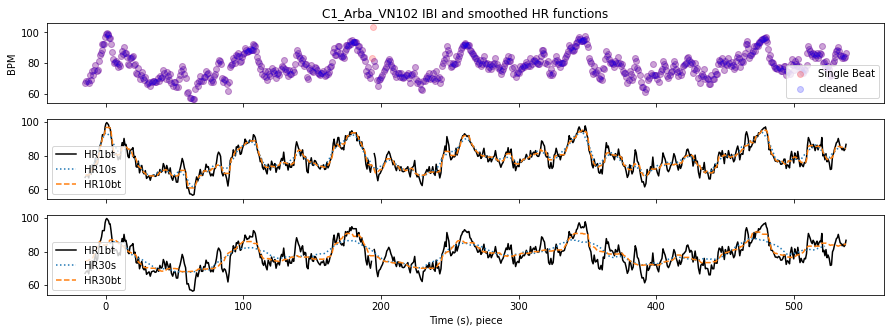

In [743]:
sig_ex = 'C1_Arba_VN102'
V = pd.read_csv(data_loc + sig_ex+'_EQCIBI.csv', index_col = 0)
sig_t = V['p_sTime']
sig_v = V['Interbeat Interval (MS)']
R = pd.read_csv(data_loc + sig_ex + '_EQRESP.csv', index_col = 0)
IBI=clean_IBI(sig_t,sig_v,activitytype='default')
beatfeats = ibi_beatfeats(IBI.index,IBI.IBI.values)
sbeatfeats = ibi_sbeatfeats(IBI.index,IBI.IBI.values)

fig, (ax) = plt.subplots(3, 1,figsize = [15,5],sharex = True)
ax[0].scatter(x =sig_t,y=(60000/sig_v),color='r',alpha = 0.2,label='Single Beat')
ax[0].scatter(x = IBI.index,y = (60000/IBI['IBI']),color='b',alpha = 0.2,label='cleaned')
ax[0].set_ylabel('BPM')
beatfeats['HR1bt'].plot(ax=ax[1],color='k')
sbeatfeats['HR10s'].plot(ax=ax[1],style=':')
beatfeats['HR10bt'].plot(ax=ax[1],style='--')
beatfeats['HR1bt'].plot(ax=ax[2],color='k')
sbeatfeats['HR30s'].plot(ax=ax[2],style=':')
beatfeats['HR30bt'].plot(ax=ax[2],style='--')
ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[2].set_xlabel('Time (s), piece')
ax[0].set_title(sig_ex +' IBI and smoothed HR functions')
plt.savefig(plot_loc+'_'.join([sig_ex,'HRfeats'])+'.png',dpi=mydpi)
plt.show()

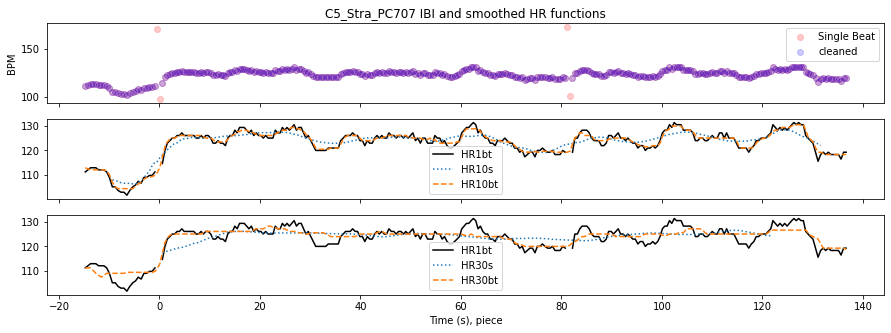

In [744]:
sig_ex = 'C5_Stra_PC707'
V = pd.read_csv(data_loc + sig_ex+'_EQCIBI.csv', index_col = 0)
sig_t = V['p_sTime']
sig_v = V['Interbeat Interval (MS)']
R = pd.read_csv(data_loc + sig_ex + '_EQRESP.csv', index_col = 0)
IBI=clean_IBI(sig_t,sig_v,activitytype='default')
beatfeats = ibi_beatfeats(IBI.index,IBI.IBI.values)
sbeatfeats = ibi_sbeatfeats(IBI.index,IBI.IBI.values)

fig, (ax) = plt.subplots(3, 1,figsize = [15,5],sharex = True)
ax[0].scatter(x =sig_t,y=(60000/sig_v),color='r',alpha = 0.2,label='Single Beat')
ax[0].scatter(x = IBI.index,y = (60000/IBI['IBI']),color='b',alpha = 0.2,label='cleaned')
ax[0].set_ylabel('BPM')
beatfeats['HR1bt'].plot(ax=ax[1],color='k')
sbeatfeats['HR10s'].plot(ax=ax[1],style=':')
beatfeats['HR10bt'].plot(ax=ax[1],style='--')
beatfeats['HR1bt'].plot(ax=ax[2],color='k')
sbeatfeats['HR30s'].plot(ax=ax[2],style=':')
beatfeats['HR30bt'].plot(ax=ax[2],style='--')
ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[2].set_xlabel('Time (s), piece')
ax[0].set_title(sig_ex +' IBI and smoothed HR functions')
plt.savefig(plot_loc+'_'.join([sig_ex,'HRfeats'])+'.png',dpi=mydpi)
plt.show()

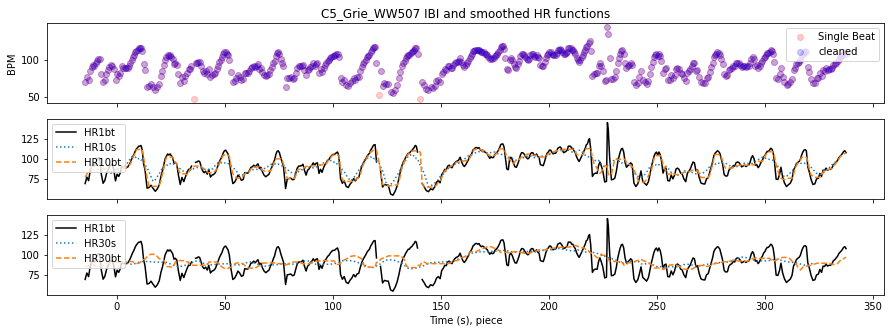

In [746]:
sig_ex = 'C5_Grie_WW507'
V = pd.read_csv(data_loc + sig_ex+'_EQCIBI.csv', index_col = 0)
sig_t = V['p_sTime']
sig_v = V['Interbeat Interval (MS)']
R = pd.read_csv(data_loc + sig_ex + '_EQRESP.csv', index_col = 0)
IBI=clean_IBI(sig_t,sig_v,activitytype='resp')
beatfeats = ibi_beatfeats(IBI.index,IBI.IBI.values)
sbeatfeats = ibi_sbeatfeats(IBI.index,IBI.IBI.values)

fig, (ax) = plt.subplots(3, 1,figsize = [15,5],sharex = True)
ax[0].scatter(x =sig_t,y=(60000/sig_v),color='r',alpha = 0.2,label='Single Beat')
ax[0].scatter(x = IBI.index,y = (60000/IBI['IBI']),color='b',alpha = 0.2,label='cleaned')
ax[0].set_ylabel('BPM')
beatfeats['HR1bt'].plot(ax=ax[1],color='k')
sbeatfeats['HR10s'].plot(ax=ax[1],style=':')
beatfeats['HR10bt'].plot(ax=ax[1],style='--')
beatfeats['HR1bt'].plot(ax=ax[2],color='k')
sbeatfeats['HR30s'].plot(ax=ax[2],style=':')
beatfeats['HR30bt'].plot(ax=ax[2],style='--')
ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[2].set_xlabel('Time (s), piece')
ax[0].set_title(sig_ex +' IBI and smoothed HR functions')
plt.savefig(plot_loc+'_'.join([sig_ex,'HRfeats'])+'.png',dpi=mydpi)
plt.show()

Rolling means and medians reduce the information in the beat-wise heart rates and larger rolling ranges. Local fluctuations within the rolling interval are consistently removed, high frequency filtering. In the comparisons above, the 30s and 30bt smoothings miss repeated wide fluctations in heart rate, with inverse rises (100-150s) because the cut off period is close to the dominant frequency of the cardiac activity when the shorter intervals follow (10s and 10bt) more closely the heart rate shift. 

Depending on the kind of temporal relationship to be investigated, these filtering effect should be considered carefully. In the 100-150s interval, this player is alternating between playing and not playing, alternating every 10-15 s, heart rate increasing during play and dropping when tacet. If the relationship between playing and cardiac activity is important, than the short interval would retain more relevant information. 

The difference between means and medians are also noticeable here. Both central tendency values reduce the value range, dampening peaks and valleys, however means spread out the effects of fluctuations more than medians, shifting the timing increases and decreases to start and stop out of alignment with the original values. Again, if the interest is in associating cardiac activity and concurrent musical activities, these advances and expansions of change will make the evaluation of temporal alignment more difficult. The second plot above shows this most dramatically between the 10s mean and 10bt median. Both signals smooth some fluctuations under 4-5 s, but the 10s mean blurs the timing of heart rate changes but as much as 5 s while the median stays close to the 1 bt values for trends that are larger than the rolling interval. 

So 10bt median is looking to be closest to a smoothing function that would suit my own purposes. More examples below underline this while also demonstrating the limitations of all of these features.

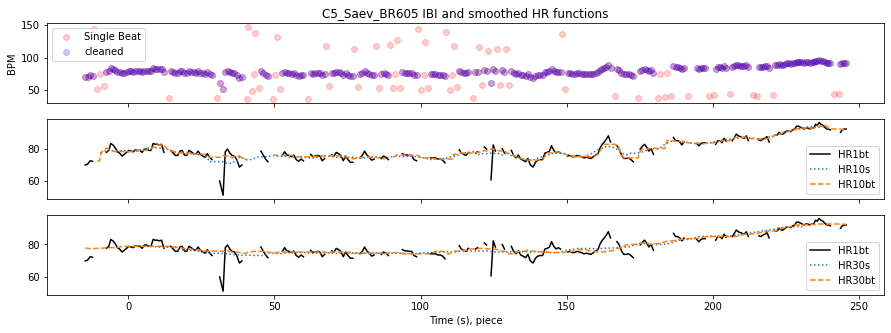

In [747]:
sig_ex = 'C5_Saev_BR605'
V = pd.read_csv(data_loc + sig_ex+'_EQCIBI.csv', index_col = 0)
sig_t = V['p_sTime']
sig_v = V['Interbeat Interval (MS)']
R = pd.read_csv(data_loc + sig_ex + '_EQRESP.csv', index_col = 0)
IBI=clean_IBI(sig_t,sig_v,activitytype='resp')
beatfeats = ibi_beatfeats(IBI.index,IBI.IBI.values)
sbeatfeats = ibi_sbeatfeats(IBI.index,IBI.IBI.values)

fig, (ax) = plt.subplots(3, 1,figsize = [15,5],sharex = True)
ax[0].scatter(x =sig_t,y=(60000/sig_v),color='r',alpha = 0.2,label='Single Beat')
ax[0].scatter(x = IBI.index,y = (60000/IBI['IBI']),color='b',alpha = 0.2,label='cleaned')
ax[0].set_ylabel('BPM')
beatfeats['HR1bt'].plot(ax=ax[1],color='k')
sbeatfeats['HR10s'].plot(ax=ax[1],style=':')
beatfeats['HR10bt'].plot(ax=ax[1],style='--')
beatfeats['HR1bt'].plot(ax=ax[2],color='k')
sbeatfeats['HR30s'].plot(ax=ax[2],style=':')
beatfeats['HR30bt'].plot(ax=ax[2],style='--')
ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[2].set_xlabel('Time (s), piece')
ax[0].set_title(sig_ex +' IBI and smoothed HR functions')
plt.savefig(plot_loc+'_'.join([sig_ex,'HRfeats'])+'.png',dpi=mydpi)
plt.show()

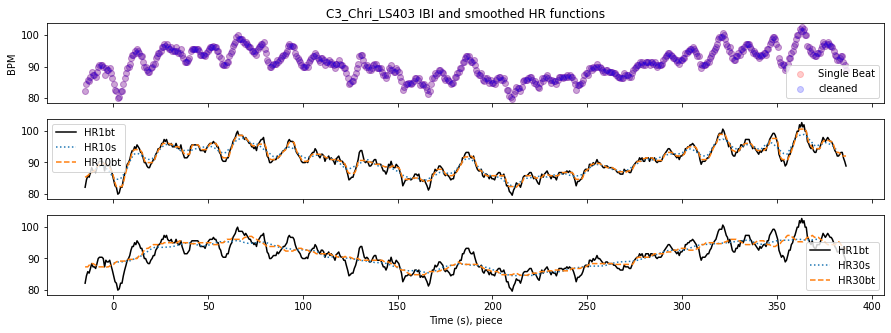

In [748]:
sig_ex = 'C3_Chri_LS403'
V = pd.read_csv(data_loc + sig_ex+'_EQCIBI.csv', index_col = 0)
sig_t = V['p_sTime']
sig_v = V['Interbeat Interval (MS)']
R = pd.read_csv(data_loc + sig_ex + '_EQRESP.csv', index_col = 0)
IBI=clean_IBI(sig_t,sig_v,activitytype='default')
beatfeats = ibi_beatfeats(IBI.index,IBI.IBI.values)
sbeatfeats = ibi_sbeatfeats(IBI.index,IBI.IBI.values)

fig, (ax) = plt.subplots(3, 1,figsize = [15,5],sharex = True)
ax[0].scatter(x =sig_t,y=(60000/sig_v),color='r',alpha = 0.2,label='Single Beat')
ax[0].scatter(x = IBI.index,y = (60000/IBI['IBI']),color='b',alpha = 0.2,label='cleaned')
ax[0].set_ylabel('BPM')
beatfeats['HR1bt'].plot(ax=ax[1],color='k')
sbeatfeats['HR10s'].plot(ax=ax[1],style=':')
beatfeats['HR10bt'].plot(ax=ax[1],style='--')
beatfeats['HR1bt'].plot(ax=ax[2],color='k')
sbeatfeats['HR30s'].plot(ax=ax[2],style=':')
beatfeats['HR30bt'].plot(ax=ax[2],style='--')
ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[2].set_xlabel('Time (s), piece')
ax[0].set_title(sig_ex +' IBI and smoothed HR functions')
plt.savefig(plot_loc+'_'.join([sig_ex,'HRfeats'])+'.png',dpi=mydpi)
plt.show()

### Retaining meaningful fluctuations in HR

To underline how the smoothing parameters proiritise different kinds of information in these cardiac measurements (interval and type), below are the features extracted from a section of performers, the second violinists during one piece of music. The Carnival of Venice alternates between orchestra and soloist, and some fluctuations are at the rate of these alternations and some simultaneous changes are at a smaller scale, maybe at the phrase level rather than section. 

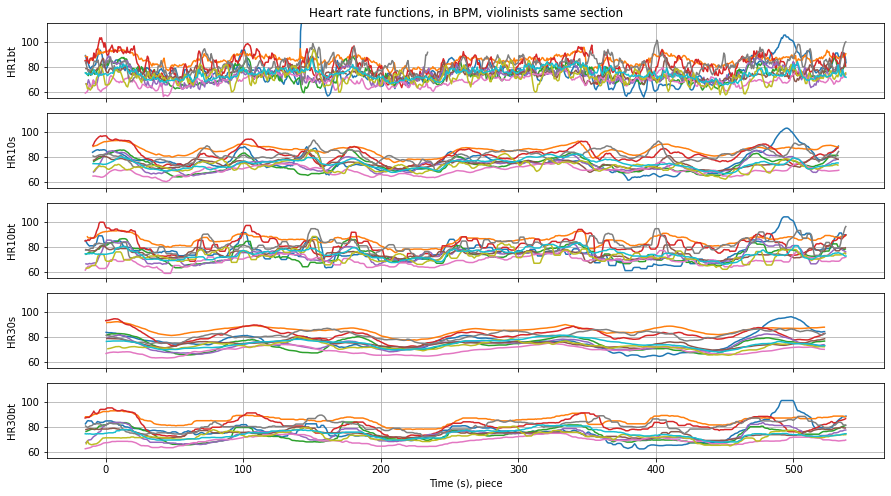

In [754]:
sig_ex = 'C1_Arba_VN'
fig, (ax) = plt.subplots(5, 1,figsize = [15,8],sharex = True)
tag = ['HR1bt','HR10s','HR10bt','HR30s','HR30bt']
for i in range(10):
    V = pd.read_csv(data_loc + sig_ex+str(i+201)+'_EQCIBI.csv', index_col = 0)
    sig_t = V['p_sTime']
    sig_v = V['Interbeat Interval (MS)']
    IBI=clean_IBI(sig_t,sig_v,activitytype='default')
    beatfeats = ibi_beatfeats(IBI.index,IBI.IBI.values)
    sbeatfeats = ibi_sbeatfeats(IBI.index,IBI.IBI.values)
    for j in range(len(ax)):
        if tag[j].endswith('s'):
            sbeatfeats[tag[j]].plot(ax=ax[j])
        else:
            beatfeats[tag[j]].plot(ax=ax[j])
ax[4].set_xlabel('Time (s), piece')
ax[0].set_title('Heart rate functions, in BPM, violinists same section')
for j in range(5):
    ax[j].grid()
    ax[j].set_ylim([55,115])
    ax[j].set_ylabel(tag[j])
    
plt.savefig(plot_loc+'_'.join([sig_ex,'HRfeats'])+'.png',dpi=mydpi)
plt.show()

Smoothing these heart rate time series with 30 s averages retaines only a rough and temporally distorted contour, removing numerous shared peaks between players performing the same part (ex 150s). Smoothing average at 10 s retains more, but still shifts the timing of changes to make concurrent local changes is obscured. 

The median tiem series are filtering higher frequency fluctuations but also relatin more alignment in the timing of heart rate changes. The 10 bt median is close to the rate of common patterns in heart rate oscillations, many instances are retained but not all. If the quality of IBI information is sufficiently stable maybe an 8 bt median would be more reliable yet. 

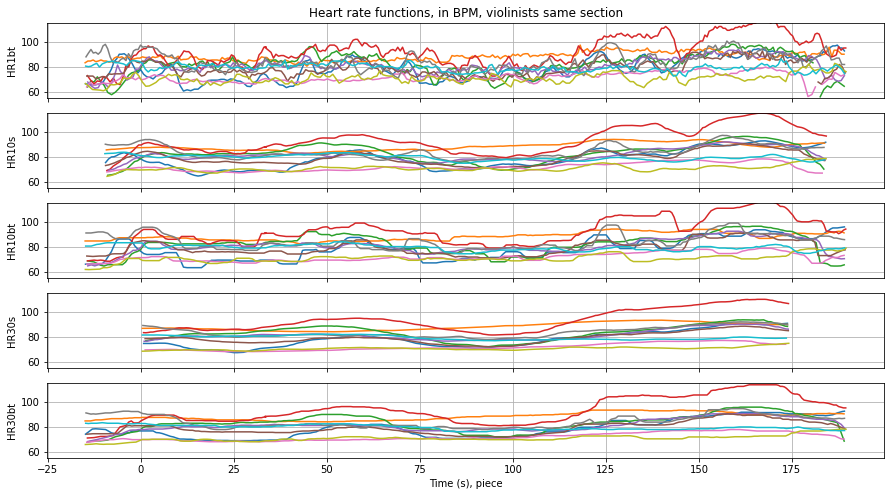

In [752]:
sig_ex = 'C1_Tcha_VN'
fig, (ax) = plt.subplots(5, 1,figsize = [15,8],sharex = True)
tag = ['HR1bt','HR10s','HR10bt','HR30s','HR30bt']
for i in range(10):
    V = pd.read_csv(data_loc + sig_ex+str(i+201)+'_EQCIBI.csv', index_col = 0)
    sig_t = V['p_sTime']
    sig_v = V['Interbeat Interval (MS)']
    IBI=clean_IBI(sig_t,sig_v,activitytype='default')
    beatfeats = ibi_beatfeats(IBI.index,IBI.IBI.values)
    sbeatfeats = ibi_sbeatfeats(IBI.index,IBI.IBI.values)
    for j in range(len(ax)):
        if tag[j].endswith('s'):
            sbeatfeats[tag[j]].plot(ax=ax[j])
        else:
            beatfeats[tag[j]].plot(ax=ax[j])
ax[4].set_xlabel('Time (s), piece')
ax[0].set_title('Heart rate functions, in BPM, violinists same section')
for j in range(5):
    ax[j].grid()
    ax[j].set_ylim([55,115])
    ax[j].set_ylabel(tag[j])
    
plt.savefig(plot_loc+'_'.join([sig_ex,'HRfeats'])+'.png',dpi=mydpi)
plt.show()

Looking at a shorter piece with a more typical structure, these violinists show again somewhat similar contours with the 30s means, but the there is a lot of shared and distinguising variation in heart rate that are most visibile in the 10 bt medians. 

However, in this piece as well, it seems like the 10 bt median is still flattening local changes in heart rate that seem to be coordinated across players in the same section. Again, if the quality of the IBI measurements are sufficiently high, it may be that 8 bts would be a better threshold, and there maybe conditions when then 1 bt time series are worth working with.

Heart rates fluctuate rapidly in people playing music. The work of performance is demanding and variable in relationship to the specific actions. There are also other aspects of a person's cognitive state and health condition that can influence the particular cardiac dynamics measured in these contexts. 

Resample these cardiac features at an even 4 hz to make them comparable between bodies concurrently active. We can then use comparative measures to evaluate what kind of information shared between players is retained through the various transformations. 

In [762]:
sig_ex = 'C1_Arba_VN'
i = 0
V = pd.read_csv(data_loc + sig_ex+str(i+201)+'_EQCIBI.csv', index_col = 0)
sig_t = V['p_sTime']
sf = 4
time_s = np.arange(np.round(sig_t.iloc[0]),np.round(sig_t.iloc[-1]),1/sf)
df_sig = pd.DataFrame(index = time_s)
cols = ['IBI', 'HR1bt', 'normHR1bt', 'HR10bt', 'HR30bt', 'HR10s', 'HR30s']
HR_dfs = {}
for c in cols:
    HR_dfs[c] = df_sig.copy()

for i in range(10):
    V = pd.read_csv(data_loc + sig_ex+str(i+201)+'_EQCIBI.csv', index_col = 0)
    sig_t = V['p_sTime']
    sig_v = V['Interbeat Interval (MS)']
    IBI=clean_IBI(sig_t,sig_v,activitytype='default')
    beatfeats = ibi_beatfeats(IBI.index,IBI.IBI.values)
    sbeatfeats = ibi_sbeatfeats(IBI.index,IBI.IBI.values)
    rf = refeats(beatfeats,time_s)
    for c in ['IBI', 'HR1bt', 'normHR1bt', 'HR10bt', 'HR30bt']:
        HR_dfs[c].loc[:,i] = rf.loc[:,c]
    rf = refeats(sbeatfeats,time_s)
    for c in ['HR10s', 'HR30s']:
        HR_dfs[c].loc[:,i] = rf.loc[:,c]

The reliability of these features is considered at a few time scales and with a couple of correlation tools on the original measurements and on the first order difference of these time series (at 4 Hz).

The one is the distribution of correlation between measurements pairs across a whole piece. This measure is controversial (Upham & McAdams, 2018) but it should be familiar. For each feature, the histogram of values and summary statistics are shared below.  

The second is the SMMS ratio, or the ratio of the standard deviation of the mean time series against the average standard deviation of each measurement (Upham, 2013). When this SMMS ratio is close to one, that means that the signals are very similar, sharing information in phase instead of cancelling out with offsets. If the mean signal is much flatter than the respective measurements, the ratio will be close to zero, meaning the signals are not well aligned. This caculation is is shared for the whole measurement interval (last value), and also assessed in rolling frames of sizes 2s to 64s (exponential scale).  

HR1bt rho =  0.351 (0.157), SMMS ratio 0.628
HR1btdiff rho =  0.045 (0.041), SMMS ratio 0.378


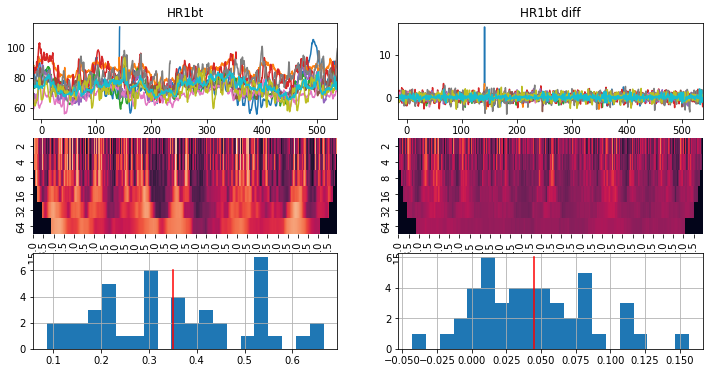

HR10bt rho =  0.405 (0.168), SMMS ratio 0.67
HR10btdiff rho =  0.116 (0.086), SMMS ratio 0.45


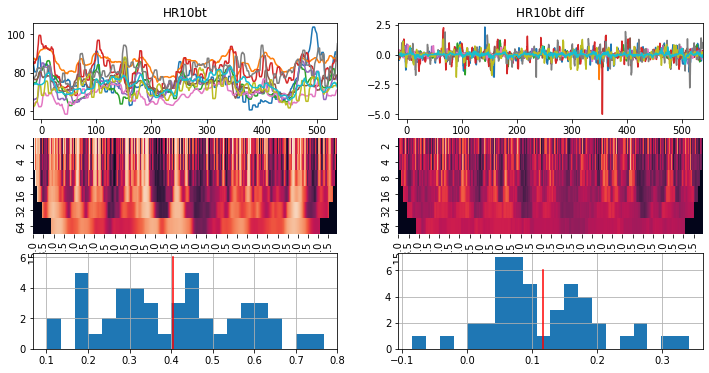

HR10s rho =  0.432 (0.18), SMMS ratio 0.692
HR10sdiff rho =  0.205 (0.125), SMMS ratio 0.53


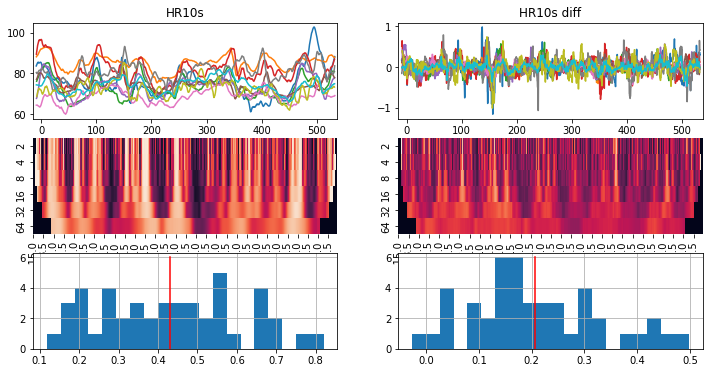

HR30bt rho =  0.45 (0.177), SMMS ratio 0.707
HR30btdiff rho =  0.213 (0.12), SMMS ratio 0.5


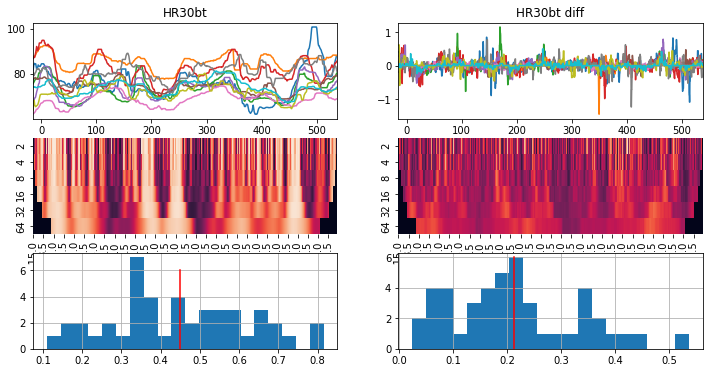

HR30s rho =  0.46 (0.197), SMMS ratio 0.724
HR30sdiff rho =  0.305 (0.188), SMMS ratio 0.601


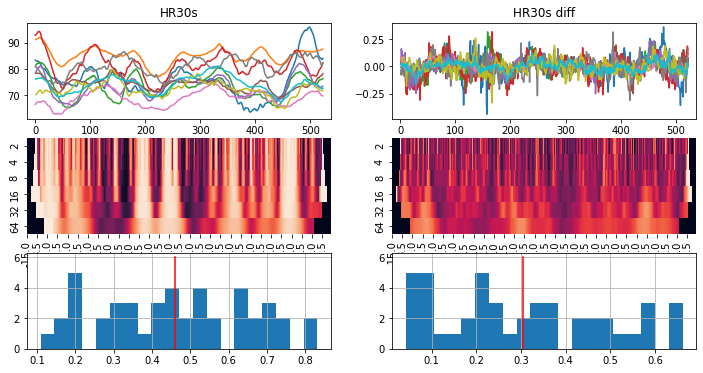

In [763]:
cols = ['HR1bt','HR10bt', 'HR10s','HR30bt',  'HR30s']
frame_sizes = [2,4,8,16,32,64]
for c in cols:
    fig, (ax) = plt.subplots(3,2,figsize = [12,6])
    HR_dfs[c].plot(ax=ax[0,0],legend=False)
    ax[0,0].set_title(c)
    HR_dfs[c].diff().plot(ax=ax[0,1],legend=False)
    ax[0,1].set_title(c+' diff')
#     ax[0,0].autoscale(enable=True, axis='x', tight=True)
#     ax[0,1].autoscale(enable=True, axis='x', tight=True)
    ax[0,0].set_xlim([HR_dfs[c].index[0],HR_dfs[c].index[-1]])
    ax[0,1].set_xlim([HR_dfs[c].index[0],HR_dfs[c].index[-1]])

    pcoor = scaledcoh(HR_dfs[c],frame_sizes)
    no_na = pcoor.fillna(0)
    chart = sns.heatmap(data=no_na.transpose(),vmin=0, vmax=1, ax=ax[1,0],cbar=False)#
    pcoor = scaledcoh(HR_dfs[c].diff(),frame_sizes)
    no_na = pcoor.fillna(0)
    chart = sns.heatmap(data=no_na.transpose(),vmin=0, vmax=1, ax=ax[1,1],cbar=False)#

    a = HR_dfs[c].corr(method='spearman')
    keep = np.triu(np.ones(a.shape),1).astype('bool').reshape(a.size)
    b = (a.stack()[keep])
    b.hist(bins = 20,ax=ax[2,0])
    m = b.mean()
    ax[2,0].plot(m*np.array([1,1]),[0,6],color = 'r')
    devR = HR_dfs[c].mean(axis=1).std()/HR_dfs[c].std(axis=0).mean()
    print(' '.join([c,'rho = ', str(np.round(m,3)),'('+str(np.round(b.std(),3))+'),','SMMS ratio',str(np.round(devR,3))]))
    a = HR_dfs[c].diff().corr(method='spearman')
    b = (a.stack()[keep])
    b.hist(bins = 20,ax=ax[2,1])
    dm = b.mean()
    ax[2,1].plot(dm*np.array([1,1]),[0,6],color = 'r')
    devR = HR_dfs[c].diff().mean(axis=1).std()/HR_dfs[c].diff().std(axis=0).mean()
    print(' '.join([c+'diff','rho = ',str(np.round(dm,3)),'('+str(np.round(b.std(),3))+'),','SMMS ratio',str(np.round(devR,3))]))
    plt.savefig(plot_loc+'_'.join([sig_ex,c,'featCoh'])+'.png',dpi=mydpi)
    plt.show()

Going only by the coherence strength caught across the whole excerpt, the more smoothed Heart rate functions (30 s average) show the highest values of pairwise correlations. However, there is a cost to local information, with less distinctive variation in SMMS ratios over small frames, and some peaks that contradict pattern tangeable with smaller smoothing ranges. 

The means also show stronger local information suppression than the medians in these local multiscale coherence plots. 

The gain of cross-section variation strenght from HR1bt (beatwise heart rate from cleaned IBIs) to HR10bt (median on 10 bts) is suits my own research priorities, retaining heart rate changes at the scale of musical phrases.